<a href="https://colab.research.google.com/github/giustinod/nir-data/blob/main/CNN_optimization_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tutorial on automated optimization of deep spectral modelling for regression and classification**

cfr. https://github.com/dario-passos/DeepLearning_for_VIS-NIR_Spectra

Installazione librerie utilizzate, import e definizione funzioni di utilità.

In [48]:
!pip3 install tensorflow_addons
!pip3 install livelossplot
!pip3 install optuna
!pip3 install sklearn
!pip3 install boto3
!pip3 install spectral
!pip3 install pyod
!pip3 install cleanlab
!pip3 install scikeras[tensorflow]

## Import external libraries
import os
import json
import sys
from sys import stdout
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm
import seaborn as sns 
import pandas as pd
import logging
import tqdm

# import nippy
import boto3
from botocore.exceptions import ClientError

from scipy.signal import savgol_filter, general_gaussian

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical  

from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.metrics import accuracy_score
import sklearn.model_selection as ms
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.decomposition import PCA

## Use liveslossplot for training visualization in real time
from livelossplot import PlotLossesKerasTF
import optuna

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, data_table
from oauth2client.client import GoogleCredentials

## Check for version of installed packages in the system
print('Tensorflow ', tf.__version__)
print('Tensorflow add-ons ', tfa.__version__)
print('tqdm ', tqdm.__version__)
print('Numpy ', np.__version__)
print('Pandas', pd.__version__)
print('Optuna ', optuna.__version__)
# print('livelossplot ', livelossplot.__version__)
# print('Scikit-learn ', sklearn.__version__)
print('Boto3 ', boto3.__version__)

# 2) Help functions

## Define random seeds ir order to maintain reproducible results through multiple testing phases
def reproducible_comp():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
reproducible_comp()

# Define a help function to compute the Standard Normal Variate correction to the spectra

def snv(input_data):
    # Define a new array and populate it with the corrected data  
    # return (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
      if np.all(np.std(input_data[i,:]) != 0):
        # Apply correction
        c = 0.
        if np.std(input_data[i,:]) == 0:
          c += 0.001
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / (np.std(input_data[i,:]) + c)
      else:
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:]))
    return output_data

# Define functions to standardize the data in columns

## Define a couple of help functions
## Function to standardize a data set column-wise

def standardize_column(X_train, X_calib, X_test):
    ## We train the scaler on the train set and apply it to the other datasets
    scaler = StandardScaler().fit(X_train)
    ## for columns we fit the scaler to the train set and apply it to the test set
    X_train_scaled = scaler.transform(X_train)
    X_calib_scaled = scaler.transform(X_calib)
    X_test_scaled = scaler.transform(X_test)
    return [X_train_scaled, X_calib_scaled, X_test_scaled]

# Custom function to compute grad-CAM scores

## Adapted for 1d input data from https://keras.io/examples/vision/grad_cam/
    
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient
    ## over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(1))

    ## We multiply each channel in the feature map array
    ## by "how important this channel is" with regard to the top predicted class
    ## then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose, we will also normalize the heatmap between 0 & 1
    #   heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()    

# Customized linecolor function for grad-CAM heatmap production

## Code adapted from: https://github.com/dpsanders/matplotlib-examples/blob/master/colorline.ipynb

## Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
## The color is taken from optional data in z, and creates a LineCollection.

## z can be:
## - empty, in which case a default coloring will be used based on the position along the input arrays
## - a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
## - an array of the length of at least the same length as x, to color according to this data
## - an array of a smaller length, in which case the colors are repeated along the curve

## The function colorline returns the LineCollection created, which can be modified afterwards.

## Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments

## Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('jet'), norm=colors.Normalize(vmin=0.0, vmax=1), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
#     plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    return lc
            
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

# Defining functions to be used in the Learning Rate range test

## Source: 
#  https://www.kaggle.com/avanwyk/tf2-super-convergence-with-the-1cycle-policy
#  https://www.avanwyk.com/tensorflow-2-super-convergence-with-the-1cycle-policy/

## Functions to implement the LR scheduler using OneCycleScheduler

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos

class OneCycleScheduler(Callback):
    """`Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')
        
class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 1000, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(8,6))
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses, lw=2)    

# Set parameters for graphics formating

## Graphics settings
## Setting the font sizes for comming figures
# plt.style.use("default")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

## uncomment for Latex graphics formating
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": ["Times"]})

# plt.rc('text', usetex=True)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Aggiunte 
s3_client = boto3.client('s3', aws_access_key_id = '...', 
                         aws_secret_access_key = '...')

def upload_file(file_name, bucket = 'pls-regression', object_name = None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = os.path.basename(file_name)

    # Upload the file
    try:
        response = s3_client.upload_file(file_name, bucket, 'saved_models/' + object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

def conv(cl):
    if cl == 'Carta':
        return 0
    if cl == 'VetroCarta':
        return 1
    if cl == 'Ceramiche':
        return 2
    if cl == 'Opalino':
        return 3
    if cl == 'Plastica':
        return 4
    if cl == 'Vetro':
        return 5
    if cl == 'VetroCeramica':
        return 6
    if cl == 'BackGround':
        return 7
    return 9   # default case if x is not found

# https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/
def msc(input_data, reference = None):
    ''' Perform Multiplicative scatter correction'''
 
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
 
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        c = 0.
        if fit[0][0] == 0:
          c += 0.001
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / (fit[0][0] + c)

    return (data_msc)

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

data_table.enable_dataframe_formatter()

selected_classes = (1, 2, 3, 5, 6)
df_map = {1: 0, 2: 1, 3: 2, 5: 3, 6: 4} # mapping selected classes to interval 0-n.
n_classes = 5

## Create the base model to be used in LRFinder only
def create_base_model():
    ## Layers dimensions
    INPUT_DIMS = 121 * 6 # np.shape(x_cal_scaled_col)[1]
    CONV1D_DIMS = INPUT_DIMS
    K_NUMBER = 1
    K_WIDTH = 13
    K_STRIDE = 1
    FC1_DIMS = 512
    FC2_DIMS = 128
    FC3_DIMS = 32
    OUT_DIMS = n_classes
    
    ## L2 regularizer parameter
    beta = 0.003/2.
    
    ## For the sake of simplicity we do the weights initialization for multiple layers here
    ## Due to this, we might have to re-run this cell before each experiment to ensure proper weight initialization each time
    K_INIT = tf.keras.initializers.he_normal(seed=42)
    
    ## Weights L2 regularization 
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## This is where the CNN architecture is define, layer after layer.
    model_cnn = keras.Sequential([  keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,)), \
                                    keras.layers.Conv1D(filters=K_NUMBER, \
                                                        kernel_size=K_WIDTH, \
                                                        strides=K_STRIDE, \
                                                        padding='same', \
                                                        kernel_initializer=K_INIT,\
                                                        kernel_regularizer=K_REG,\
                                                        activation='relu',\
                                                        input_shape=(CONV1D_DIMS,1)), \
                                    keras.layers.MaxPooling1D(pool_size=8, \
                                                        strides=K_STRIDE, \
                                                        padding="same", \
                                                        data_format="channels_last"), \
                                    keras.layers.Flatten(),
                                    keras.layers.BatchNormalization(renorm=True),
                                    keras.layers.Dense(FC1_DIMS, \
                                                       kernel_initializer=K_INIT, \
                                                       kernel_regularizer=K_REG, \
                                                       activation='relu'),
                                    keras.layers.Dropout(0.26, input_shape=(CONV1D_DIMS,1)),
                                    keras.layers.Dense(FC2_DIMS, \
                                                       kernel_initializer=K_INIT,\
                                                       kernel_regularizer=K_REG,\
                                                       activation='relu'),
                                    keras.layers.Dropout(0.26, input_shape=(CONV1D_DIMS,1)),
                                    keras.layers.Dense(FC3_DIMS, \
                                                       kernel_initializer=K_INIT, \
                                                       kernel_regularizer=K_REG, \
                                                       activation='relu'),
                                    keras.layers.Dropout(0.26, input_shape=(CONV1D_DIMS,1)),
                                    keras.layers.Dense(OUT_DIMS, kernel_initializer=K_INIT, \
                                                       kernel_regularizer=K_REG,\
                                                       activation='softmax'),
                                  ], name='BASE_MODEL')
    
    return model_cnn

## Settings for the smooth derivatives using a Savitsky-Golay filter
w = 7 ## Sav.Gol window size
p = 3 ## Sav.Gol polynomial degree

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow  2.8.0
Tensorflow add-ons  0.16.1
tqdm  4.64.0
Numpy  1.21.6
Pandas 1.3.5
Optuna  2.10.0
Boto3  1.22.4
Found GPU at: /device:GPU:0


**3) Data wrangling**

Pre-trattamenti dei dati, qui ho sostituito quelli originali con quelli utilizzati in calibrazioni-nir per la classificazione e basati su nippy.

Il tutorial utilizza tre dataset:

*   cal_features -> calibrazione, usato per il training del modello
*   val_features -> validazione, usato per il tuning degli hyperparametri. Chiamato anche tuning set
*   pre_features -> test, su questi dati il modello ottimizzato viene "testato" per misurare la performance finale

Gli array cal_labels, val_labels e pre_labels contengono le label corrispondenti.

I dataset sono ottenuti da quello ricevuto il 15 aprile 2022 da L.Rossi.

Per la rimozione degli outliers è stata usata la libreria PyOD. Cfr. *Zhao, Y., Nasrullah, Z. and Li, Z., 2019. PyOD: A Python Toolbox for Scalable Outlier Detection. Journal of machine learning research (JMLR), 20(96), pp.1-7*.


Outliers COPOD # (33,)
Outliers COPOD # (45,)
Outliers COPOD # (13,)
Outliers COPOD # (30,)
Outliers COPOD # (25,)
Dims validation ds:  (11092, 122)
       1050.0
Class        
0        3058
1        2837
2        1310
3        2048
4        1839
Outliers COPOD # (108,)
Outliers COPOD # (103,)
Outliers COPOD # (41,)
Outliers COPOD # (66,)
Outliers COPOD # (56,)
Dims training ds:  (24361, 122)
       1050.0
Class        
0        6696
1        6237
2        2872
3        4506
4        4050
INFO:tensorflow:Assets written to: ram:///tmp/tmpcg8k4zqm/assets
Epoch 1/10
609/609 [==============================] - 4s 5ms/step - loss: 1.7331 - acc: 0.2808
Epoch 2/10
609/609 [==============================] - 3s 5ms/step - loss: 1.1386 - acc: 0.2706
Epoch 3/10
609/609 [==============================] - 3s 5ms/step - loss: 1.0090 - acc: 0.2695
Epoch 4/10
609/609 [==============================] - 3s 5ms/step - loss: 0.9171 - acc: 0.2662
Epoch 5/10
609/609 [==============================] - 3s 5ms/

,Class Index,Label Issues,Inverse Label Issues,Label Noise,Inverse Label Noise,Label Quality Score
0,3,282,433,0.062583,0.092978,0.937417
1,1,343,227,0.054994,0.037085,0.945006
2,4,214,182,0.052840,0.045296,0.947160
3,0,185,180,0.027628,0.026902,0.972372
4,2,25,27,0.008705,0.009395,0.991295



Class Overlap. In some cases, you may want to merge classes in the top rows (below)
-----------------------------------------------------------------------------------



,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,3,4,342,0.014039
1,1,3,276,0.011330
2,0,1,242,0.009934
3,0,3,83,0.003407
4,0,4,39,0.001601
5,1,2,37,0.001519
6,1,4,15,0.000616
7,2,3,14,0.000575
8,0,2,1,0.000041
9,2,4,0,0.000000



 * Overall, about 4% (1,049 of the 24,361) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.96.

Generated with <3 from Cleanlab.



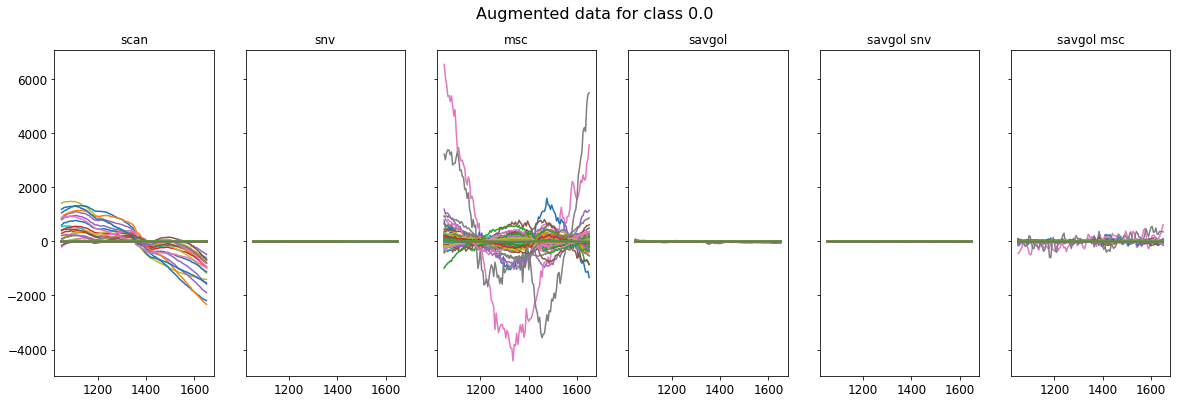

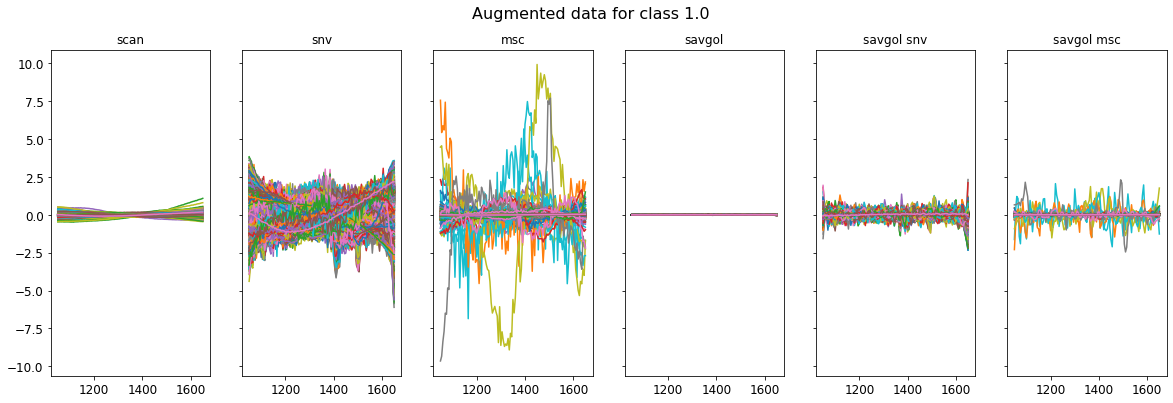

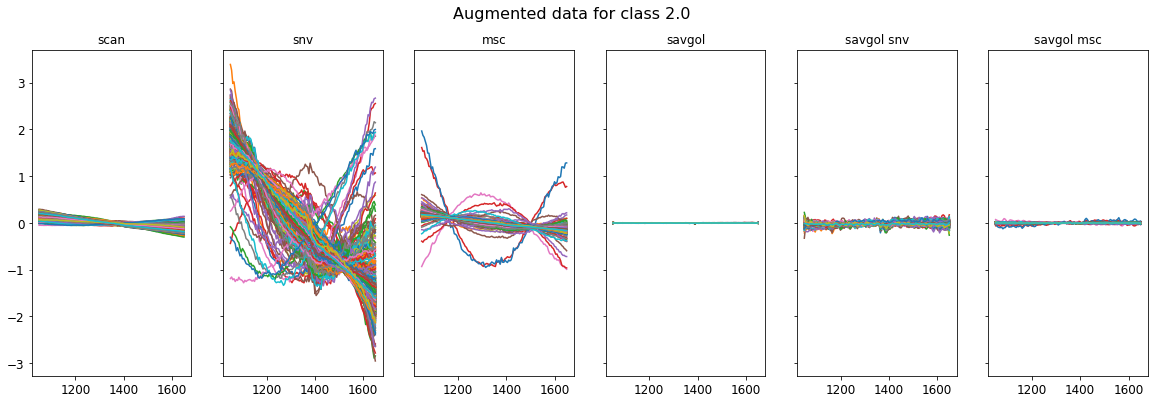

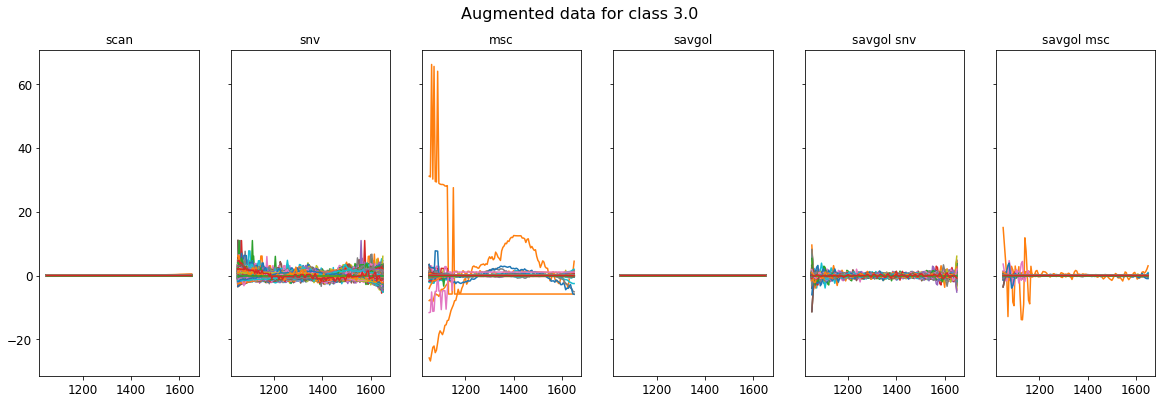

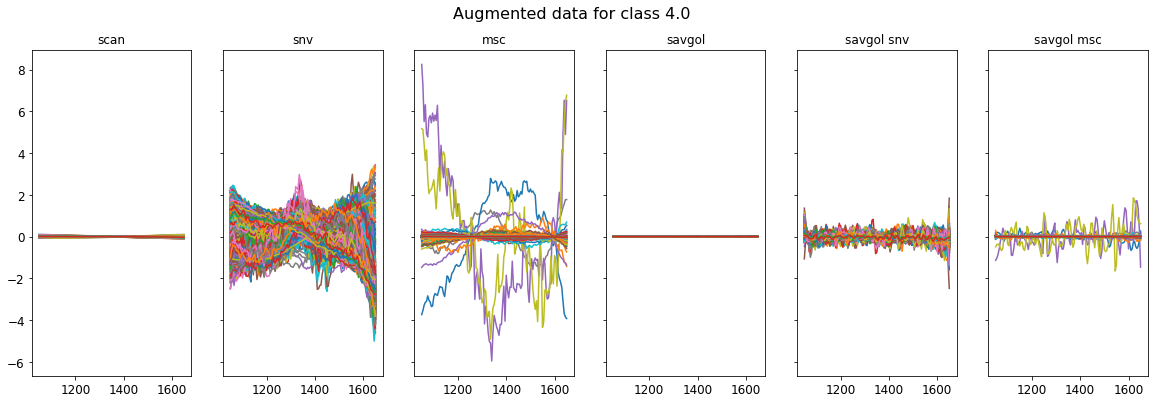

True

In [65]:
from pyod.models.copod import COPOD
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.mcd import MCD
from pyod.models.iforest import IForest

import cleanlab
from scikeras.wrappers import KerasClassifier
from pickle import dump

# Lettura CSV da google drive attraverso l'ID
downloaded = drive.CreateFile({'id': '1IZMAQESytOykfKrp--LZA4UgZmZuuPPl'})
downloaded.GetContentFile('DataSetTraining.csv')
downloaded = drive.CreateFile({'id': '1Aqlq4j0HIRNsBxnHRdhCf5GFYVjMnov_'})
downloaded.GetContentFile('DataSetValidation.csv')
downloaded = drive.CreateFile({'id': '1vF-9KmYq32pVy0z4FGgnrGtLhhXYXBnk'})
downloaded.GetContentFile('DataSetTraining2.csv')
downloaded = drive.CreateFile({'id': '1kD7TdvLdQoPnetEshS0BBMQ9mKp76m6c'})
downloaded.GetContentFile('DataSetValidation2.csv')

pd.options.mode.chained_assignment = None  # default='warn'

mpy = COPOD()

outliers_threshold = 500

df = pd.read_csv('DataSetValidation.csv', header=0)
df = df.loc[df['Class'].isin(selected_classes)]
df = df.replace({"Class": df_map})

# df2 = pd.read_csv('DataSetValidation2.csv', header=0)
# df2 = df2.loc[df['Class'].isin(selected_classes)]
# df2 = df2.replace({"Class": df_map})
# df2_0 = df2.loc[df['Class'] == 0].sample(frac = 0.1, axis = 0, replace = False)
# df2_1 = df2.loc[df['Class'] == 1].sample(frac = 0.1, axis = 0, replace = False)

# sampling same number of rows for each class
dfv = pd.DataFrame(data=None, columns=df.columns)
# dfv = pd.concat([dfv, df2_0], ignore_index = True)
# dfv = pd.concat([dfv, df2_1], ignore_index = True)
for i in df_map.values():
  perc = 1
  if i == 1: 
    perc = 0.2
  if i == 3:
    perc = 0.09

  df1 = df.loc[df['Class'] == i].sample(frac = perc, axis = 0, replace = False)
  df1.reset_index(drop = True, inplace = True)
  X = df1.values[:, 1:]
  fitted = mpy.fit(X)
  scores = mpy.decision_function(X)
  # print(scores)
  to_del = [ j for (i, j) in zip(scores, np.arange(0, scores.shape[0], 1)) if i >= outliers_threshold ]
  print('Outliers COPOD #', np.unique(to_del).shape)
  df1.drop(to_del, axis = 0, inplace = True)
  dfv = pd.concat([dfv, df1], ignore_index = True)

dfv = dfv.astype({"Class": np.int64})
print('Dims validation ds: ', dfv.shape)
print(dfv.groupby(['Class']).count().iloc[:, :1])

pre_features = dfv.values[:, 1:]
pre_labels = dfv.values[:, 0]

df = pd.read_csv('DataSetTraining.csv', header=0)
df = df.loc[df['Class'].isin(selected_classes)]
df = df.replace({"Class": df_map})
# print(df.groupby(['Class']).count().iloc[:, :1])

# df2 = pd.read_csv('DataSetTraining2.csv', header=0)
# df2 = df2.loc[df['Class'].isin(selected_classes)]
# df2 = df2.replace({"Class": df_map})
# df2_0 = df2.loc[df['Class'] == 0].sample(frac = 0.1, axis = 0, replace = False)
# df2_1 = df2.loc[df['Class'] == 1].sample(frac = 0.1, axis = 0, replace = False)

# sampling same number of rows for each class
dft = pd.DataFrame(data=None, columns=df.columns)
# dft = pd.concat([dft, df2_0], ignore_index = True)
# dft = pd.concat([dft, df2_1], ignore_index = True)
for i in df_map.values():

  perc = 1
  if i == 1: 
    perc = 0.2
  if i == 3:
    perc = 0.09

  df1 = df.loc[df['Class'] == i].sample(frac = perc, axis = 0, replace = False)
  df1.reset_index(drop = True, inplace = True)
  X = df1.values[:, 1:]
  fitted = mpy.fit(X)
  scores = mpy.decision_function(X)
  to_del = [ j for (i, j) in zip(scores, np.arange(0, scores.shape[0], 1)) if i >= outliers_threshold ]
  print('Outliers COPOD #', np.unique(to_del).shape)
  df1.drop(to_del, axis = 0, inplace = True)
  dft = pd.concat([dft, df1], ignore_index = True)

dft = dft.astype({"Class": np.int64})
print('Dims training ds: ', dft.shape)
print(dft.groupby(['Class']).count().iloc[:, :1])

cv_features = dft.values[:, 1:]
cv_labels = dft.values[:, 0]

## Create new model with optmized hyperparamters
model_base = create_base_model() 

## Compile the model using sparse_categorical_crossentropy for cleanlab
model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
              loss="sparse_categorical_crossentropy", metrics=["acc"])

kc_model = KerasClassifier(model_base, epochs=10)

# Cleanlab works with **any classifier**. Yup, you can use sklearn/PyTorch/TensorFlow/XGBoost/etc.
cl = cleanlab.classification.CleanLearning(kc_model)

cv_features1 = np.concatenate((cv_features, snv(cv_features), msc(cv_features),\
                                savgol_filter(cv_features, w, polyorder = p, deriv=1),\
                                savgol_filter(snv(cv_features), w, polyorder = p, deriv=1),\
                                savgol_filter(msc(cv_features), w, polyorder = p, deriv=1)), axis = 1)

## Standardize on columns
scaler = StandardScaler().fit(cv_features1)
x_cal_scaled_col = scaler.transform(cv_features1)

# cleanlab trains a robust version of your model that works more reliably with noisy data.
y_cal_train = cv_labels.astype(int)
df_label_issues = cl.find_label_issues(x_cal_scaled_col, labels = y_cal_train)
ordered_label_issues = df_label_issues.index[df_label_issues['is_label_issue'] == True]
print('label_issues rows removed: ', ordered_label_issues.shape)
cv_features = np.delete(cv_features, ordered_label_issues.astype(int), axis = 0)
cv_labels = np.delete(cv_labels, ordered_label_issues.astype(int), axis = 0)

# A true data-centric AI package, cleanlab quantifies class-level issues and overall data quality, for any dataset.
cleanlab.dataset.health_summary(y_cal_train, confident_joint=cl.confident_joint)

# dump(cl, open('cl.pkl', 'wb'))
# upload_file('cl.pkl')

# Split data into training and testing
split_ratio = 0.3

# Split data into training and testing
cal_features, val_features, cal_labels, val_labels = \
    ms.train_test_split(cv_features, cv_labels, test_size=split_ratio, random_state=101)

## Create wavelength x-scale by interpolating the range mentioned in the original wheat paper
co = 1050 + np.arange(cal_features.shape[1]) * 5
for i in np.unique(cv_labels):
  idx = np.where(cal_labels == i)[0]
  # print('cal_labels = ', cal_labels)
  # print('idx = ', idx.shape)
  fig, ay = plt.subplots(1, 6, sharey=True, figsize=(20, 6))
  fig.suptitle('Augmented data for class ' + str(i))
  ay[0].plot(co, cal_features[idx,:].T)
  ay[0].set_title('scan')
  ay[1].plot(co, snv(cal_features[idx,:]).T)
  ay[1].set_title('snv')
  ay[2].plot(co, msc(cal_features[idx,:]).T)
  ay[2].set_title('msc')
  ay[3].plot(co, savgol_filter(cal_features[idx,:], w, polyorder = p, deriv=1).T)
  ay[3].set_title('savgol')
  ay[4].plot(co, savgol_filter(snv(cal_features[idx,:]), w, polyorder = p, deriv=1).T)
  ay[4].set_title('savgol snv')
  ay[5].plot(co, savgol_filter(msc(cal_features[idx,:]), w, polyorder = p, deriv=1).T)
  ay[5].set_title('savgol msc')
  plt.show()

## Perform data augmentation in the feature space by combining different types of typical chemometric spectral pre-processings
## con pre-trattamenti
cal_features1 = np.concatenate((cal_features, snv(cal_features), msc(cal_features),\
                                savgol_filter(cal_features, w, polyorder = p, deriv=1),\
                                savgol_filter(snv(cal_features), w, polyorder = p, deriv=1),\
                                savgol_filter(msc(cal_features), w, polyorder = p, deriv=1)), axis = 1)
val_features1 = np.concatenate((val_features, snv(val_features), msc(val_features),\
                                savgol_filter(val_features, w, polyorder = p, deriv=1),\
                                savgol_filter(snv(val_features), w, polyorder = p, deriv=1),\
                                savgol_filter(msc(val_features), w, polyorder = p, deriv=1)), axis = 1)
pre_features1 = np.concatenate((pre_features, snv(pre_features), msc(pre_features),\
                                savgol_filter(pre_features, w, polyorder = p, deriv=1),\
                                savgol_filter(snv(pre_features), w, polyorder = p, deriv=1),\
                                savgol_filter(msc(pre_features), w, polyorder = p, deriv=1)), axis = 1)

y_cal = to_categorical(cal_labels, num_classes = n_classes)
y_tuning = to_categorical(val_labels, num_classes = n_classes)
y_test = to_categorical(pre_labels, num_classes = n_classes)

## Standardize on columns
x_cal_scaled_col, x_tuning_scaled_col, x_test_scaled_col = standardize_column(cal_features1, val_features1, pre_features1)

assert not np.any(np.isnan(x_cal_scaled_col))
assert not np.any(np.isnan(x_test_scaled_col))
assert np.shape(x_cal_scaled_col)[1] == 121 * 6

# saving datasets
with open('y_cal.npy', 'wb') as f:
    np.save(f, y_cal)
upload_file('y_cal.npy')
with open('x_cal_scaled_col.npy', 'wb') as f:
    np.save(f, x_cal_scaled_col)
upload_file('x_cal_scaled_col.npy')
with open('y_tuning.npy', 'wb') as f:
    np.save(f, y_tuning)
upload_file('y_tuning.npy')
with open('x_tuning_scaled_col.npy', 'wb') as f:
    np.save(f, x_tuning_scaled_col)
upload_file('x_tuning_scaled_col.npy')
with open('x_test_scaled_col.npy', 'wb') as f:
    np.save(f, x_test_scaled_col)
upload_file('x_test_scaled_col.npy')

**4) Optimizing the Learning Rate using a LR range test**

The first hyperparameter that we will optimize is the Learning Rate (LR) of the gradient descent optimizer. In this tutorial we decided to do this separately from the other hyperparameters and show how to use a specific method called LR range finder. See manuscript for details.

This is also where we have our first contact with the DL model. As mentioned in the manuscript, we choose a 1D-CNN architecture composed by a single conv. layers (1 filter, and stride=1), followed by a block of dense (fully connected, FC) layers. The LR optimization requires the creation/definition of a base model (prior to CNN optimization). This enables us to have an idea about the best learning rate range that can be used during the training process. The assumption here is that the LR range extracted from this base model test will also work well with the optimized CNN. This seems to hold true if the final model CNN architecture does not differ to much from the base architecture (number of layers, range of units, etc). After the base model is created, we perform a Learning Rate Range test to infer the min and max useful LR values.

**4.1) Define the base CNN architecture**

For the base model we choose a CNN with 1 conv. layer followed by 4 dense layers. The number of units in the first 3 dense layers are defined using an empirical rule of thumb that tells us that the first dense layer should be between a half and a fourth of the input features to that layer and that the units in the following layers ones should decrease by a factor of 2 or 3. It is often assumed that this type of architecture (like a funnel) forces the NN to synthesize the data into higher abstraction representations. The last layer (output) has 8 units that correspond to the 8 classes of glass in our data set.

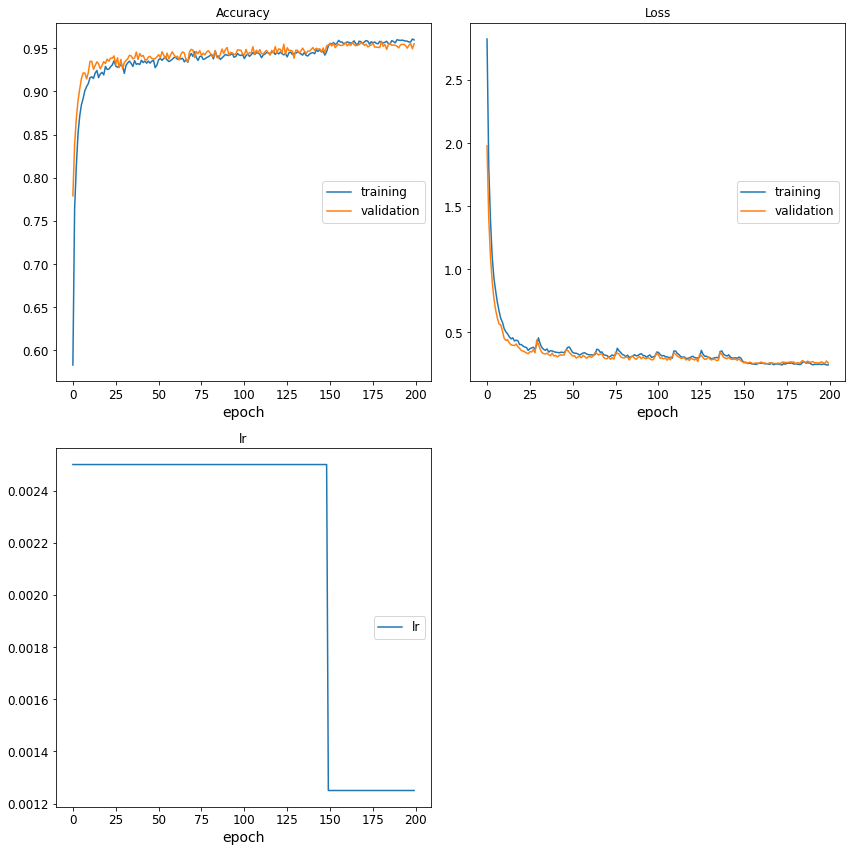

Accuracy
	training         	 (min:    0.583, max:    0.961, cur:    0.960)
	validation       	 (min:    0.779, max:    0.958, cur:    0.955)
Loss
	training         	 (min:    0.241, max:    2.824, cur:    0.242)
	validation       	 (min:    0.248, max:    1.978, cur:    0.256)
lr
	lr               	 (min:    0.001, max:    0.002, cur:    0.001)

Metrics for based CNN 
Training  Acc. ->  0.9749969358990073
Tuning  Acc. -> 0.9551043751787246
Test Acc. ->  0.8802740714028129


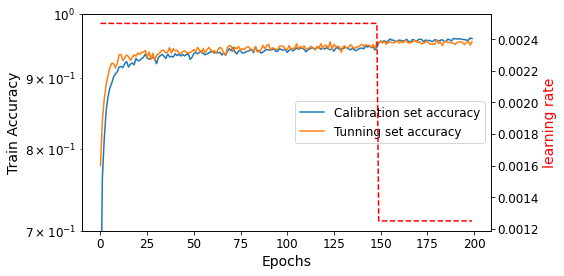

True

In [66]:
## Make computations reproducible
reproducible_comp()

# loading datasets
# s3_client.download_file('pls-regression', 'saved_models/y_cal.npy', 'y_cal.npy')
# y_cal = np.load('y_cal.npy')
# s3_client.download_file('pls-regression', 'saved_models/x_cal_scaled_col.npy', 'x_cal_scaled_col.npy')
# x_cal_scaled_col = np.load('x_cal_scaled_col.npy')
# s3_client.download_file('pls-regression', 'saved_models/y_tuning.npy', 'y_tuning.npy')
# y_tuning = np.load('y_tuning.npy')
# s3_client.download_file('pls-regression', 'saved_models/x_tuning_scaled_col.npy', 'x_tuning_scaled_col.npy')
# x_tuning_scaled_col = np.load('x_tuning_scaled_col.npy')
# s3_client.download_file('pls-regression', 'saved_models/x_test_scaled_col.npy', 'x_test_scaled_col.npy')
# x_test_scaled_col = np.load('x_test_scaled_col.npy')

## Plot the CNN layer architecture 
## The plot_model() from Keras requires that graphviz and pydot are installed in your system.
## If you dont't have these libraries installed, skip this cell for now and browse for the image "base_cnn_classification.png" in the repository to see the result

# plot_model(model_base_cnn,  to_file='base_cnn_classification.png', show_shapes=True, show_layer_names=True, \
#           rankdir='LR', expand_nested=False, dpi=96)

## define a step for the test
step_base=0.25*np.ceil(len(x_cal_scaled_col) / 512) * 400

## define the LR_range test object using the LRFinder() function predifined in the Help section.
lr_finder_base = LRFinder(start_lr= 1e-9, end_lr = 0.1, max_steps= step_base, smoothing=0.9) # 

## define a name for this model
MODEL_NAME='LR_finder_Adam_batch=_BASE_512_filter=5.h5'

## clear the session to make there is no clutter in keras
tf.keras.backend.clear_session()

#######  Callbacks #########
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=50, mode='auto', restore_best_weights=True)  
## Note that the min_lr in rdlr is the one found in the LRFinder test

rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-7, monitor='val_acc', verbose=1)

model_base = create_base_model() 

# Print a summary of the base model and plot the architecture
model_base.summary()

## Compile the model using the LRmax for the LR in Adam() 
model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
              loss="categorical_crossentropy", metrics=["acc"])

## Train new model using optimal batch size. Extend the epochs a bit to see if results improve
history0 = model_base.fit(x_cal_scaled_col, y_cal, batch_size=512, epochs=200, \
          validation_data=(x_tuning_scaled_col, y_tuning),\
          callbacks=[rdlr, early_stop, PlotLossesKerasTF() ], verbose=0)

## Make predictions on the train, tuning and test sets
pred_cal_base = model_base.predict(x_cal_scaled_col)
pred_val_base = model_base.predict(x_tuning_scaled_col)
pred_test_base = model_base.predict(x_test_scaled_col)

test_Yhat_base = np.argmax(pred_test_base,axis = 1)
cal_Yhat_base = np.argmax(pred_cal_base,axis = 1)
val_Yhat_base = np.argmax(pred_val_base,axis = 1)

## Compute accuracies
TestAcc_base = accuracy_score(pre_labels, test_Yhat_base)
CalAcc_base = accuracy_score(cal_labels, cal_Yhat_base)
ValAcc_base = accuracy_score(val_labels, val_Yhat_base)

print('\nMetrics for based CNN ')
print('Training  Acc. -> ', CalAcc_base)
print('Tuning  Acc. ->', ValAcc_base)
print('Test Acc. -> ', TestAcc_base)

## If you used Livelossplot, you can skip this. Otherwise we can take a look at the training process by plotting the
## models history.
plt.figure(figsize=(8,4))
plt.plot(history0.history['acc'], label='Calibration set accuracy')
plt.plot(history0.history['val_acc'], label='Tunning set accuracy')
plt.yscale('log')
plt.ylabel('Train Accuracy')
plt.xlabel('Epochs')
plt.ylim(0.7,1)
plt.legend(loc=5)
## In case you used ReduceLROnPlateau() you can plot the lr as well
ax2 = plt.gca().twinx()
ax2.plot(history0.history['lr'], 'r--')
ax2.set_ylabel('learning rate',color='r')
plt.tight_layout()
plt.savefig('train_tun_loss.png', dpi=96)
plt.show()

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_base.save('cnn_model.h5')
upload_file('cnn_model.h5')

**Predizione**

*   Legge l'immagine ed il modello ed esegue la predizione

In [67]:
## Import external libraries
from spectral import *
from pickle import load

# download of the CNN model previously saved on S3
# downloaded = drive.CreateFile({'id': '18cTL2klLzzDTPO73qKZ2v-qPcD6Httec'})
# downloaded.GetContentFile('best_model.h5')

# s3_client.download_file('pls-regression', 'saved_models/cnn_model.h5', 'cnn_model.h5')
cnn_model = tf.keras.models.load_model('cnn_model.h5')

# load the model from disk
# s3_client.download_file('pls-regression', 'saved_models/cl.pkl', 'cl.pkl')
# cl = load(open('cl.pkl', 'rb'))

# Check its architecture
# cnn_model.summary()

# Norm = []
"""
# Lettura CSV da google drive attraverso l'ID
downloaded = drive.CreateFile({'id': '1F5slsHtv_aTA1QuS68VzXDDEn0MTBf8l'}) # plastica/17
downloaded.GetContentFile('plastica17.hdr')
downloaded = drive.CreateFile({'id': '1IT5vnsGYZIrrPkFVjnijjRFyVTer3GPf'}) # plastica/17.hdr
downloaded.GetContentFile('plastica17')

downloaded = drive.CreateFile({'id': '1Uqggt43F9GN1YX4FcG6J7Fl4418CrIVG'}) # vetro/17.hdr
downloaded.GetContentFile('vetro17.hdr')
downloaded = drive.CreateFile({'id': '1S4TFGCO8iqLXY59Z8WflQ7dXMkC5c3Mv'}) # vetro/17
downloaded.GetContentFile('vetro17')

downloaded = drive.CreateFile({'id': '11Rz0ltIab6oDoGjk3n2hICZWMp61a-Sp'}) # vetro/3.hdr
downloaded.GetContentFile('vetro3.hdr')
downloaded = drive.CreateFile({'id': '12Cq2QSnTGXsTiGsCAMkUFnpIWPXay8X3'}) # vetro/3
downloaded.GetContentFile('vetro3')

downloaded = drive.CreateFile({'id': '1YEtFp29AHggTUbqcDmrV4IjoNIEQAb6e'}) # ceramiche/5.hdr
downloaded.GetContentFile('ceramiche5.hdr')
downloaded = drive.CreateFile({'id': '1hBiG5mghWsFA6-iIt98OGNVxe5cZRugb'}) # ceramiche/5
downloaded.GetContentFile('ceramiche5')

MyImg = open_image('plastica17.hdr')
"""
downloaded = drive.CreateFile({'id': '1AsJc7sPojNCGX8SEz64cJvXaUtOWZs88'})
downloaded.GetContentFile('DataSetTest.csv')
downloaded = drive.CreateFile({'id': '1e4xVZnjnVKCItohchaIUtDWHGOLzt_DX'})
downloaded.GetContentFile('DataSetTest2.csv')

df = pd.read_csv('DataSetTest.csv', header=0)
df = df.loc[df['Class'].isin(selected_classes)]
df = df.replace({"Class": df_map})
print('Dims: ', df.shape)

# dfd = pd.DataFrame(data=None, columns=df.columns)
# for CurrentRow in range(0, MyImg.nrows - 1):
#   for CurrentCol in range(0, MyImg.ncols - 1):
#     CurrentSpectra = MyImg[CurrentRow,CurrentCol,:]
#     scan = np.resize(CurrentSpectra, [121, 1])
#     scan1 = np.insert(scan, 0, 7, axis=0)
#     df1 = pd.DataFrame(scan1.T, columns=df.columns)
#     dfd = pd.concat([dfd, df1], ignore_index=True)

# co = np.arange(1050, 1655, 5)
# plt.plot(co, scan.T)
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Absorbance: scan')
# plt.show()

for c in np.arange(0, 5, 1):

  result = []
  dfd = df.loc[df['Class'] == c]
  scan = dfd.values[:, 1:]

  if scan.shape[0] > 0:
    print('class: ', c)
    ## Standardize on columns
    scan1 = np.concatenate((scan, snv(scan), msc(scan),\
                            savgol_filter(scan, w, polyorder = p, deriv=1),\
                            savgol_filter(snv(scan), w, polyorder = p, deriv=1),
                            savgol_filter(msc(scan), w, polyorder = p, deriv=1)), axis = 1)

    """
    output = cl.predict(scan1)
    # print(output)
    # outputp = cl.predict_proba(scan1)
    # print(outputp)
    unique, counts = np.unique(output, return_counts = True)
    print('result: ', dict(zip(unique, counts)))
    """
    output = cnn_model.predict(scan1)
    # print(output)
    # Norm.append(np.sum(output))
    result.append(np.argmax(output, axis=1)) # Mi copio nel result solo la più probabile
    # result.append(output[0]) # Mi copio nel result solo la più probabile
    res = np.array(result)
    unique, counts = np.unique(res, return_counts = True)
    print('res: ', dict(zip(unique, counts)))
    # res = np.resize(res,(MyImg.nrows, MyImg.ncols))
    # print('result: ', res)

Dims:  (35024, 122)
class:  0
res:  {0: 1023, 1: 406, 2: 650, 3: 362, 4: 33}
class:  1
res:  {0: 92, 1: 5338, 2: 1951, 3: 4116, 4: 31}
class:  2
res:  {1: 2, 2: 1056, 3: 1}
class:  3
res:  {0: 5, 1: 4761, 2: 3882, 3: 9232, 4: 590}
class:  4
res:  {1: 8, 2: 128, 3: 139, 4: 1218}


**5) Optimization of the model hyperparameters with Optuna**

In this section we perform the optimization of several model hyperparameters and make a few tweaks to the model architecture (NAS) by exploring different number of dense (or fully connected, FC) layers, dropout layers, etc. The optimization uses the Hyperband and TPE algorithms implemented in the Optuna package. In the website https://optuna.org/ you can find several examples on how to use Optuna for different settings and problems.

**5.1) Define the CNN model**

We start by redifining the CNN in a similar process done for the LR Range test. This base architecture iteratively builds the dense and dropout layers through the optimization process. The same activations and L2 regularization are used as before. This time the model is defined in terms of the model's hyperparameters that we want to optimize: number of dense layers, number of units per dense layers, convolution filter size, dropout rate, strength of the L2 regulatization. In addition, during the optimization process we will also optimize the training batch size.

In [ ]:
## Make computations reproducible
reproducible_comp()

# loading datasets
# s3_client.download_file('pls-regression', 'saved_models/y_cal.npy', 'y_cal.npy')
# y_cal = np.load('y_cal.npy')
# s3_client.download_file('pls-regression', 'saved_models/x_cal_scaled_col.npy', 'x_cal_scaled_col.npy')
# x_cal_scaled_col = np.load('x_cal_scaled_col.npy')
# s3_client.download_file('pls-regression', 'saved_models/y_tuning.npy', 'y_tuning.npy')
# y_tuning = np.load('y_tuning.npy')
# s3_client.download_file('pls-regression', 'saved_models/x_tuning_scaled_col.npy', 'x_tuning_scaled_col.npy')
# x_tuning_scaled_col = np.load('x_tuning_scaled_col.npy')

## Define the model
def create_model(num_FC_layers, num_FC_units, filter_size, DROPOUT, reg_beta):
    ## Layers dimensions
    INPUT_DIMS = np.shape(x_cal_scaled_col)[1]
    CONV1D_DIMS = INPUT_DIMS
    K_NUMBER = 1
    K_WIDTH = filter_size
    K_STRIDE = 1
    OUTPUT_DIMS = np.shape(y_cal)[1] ## Number of classes in the data
    
    ## Global (all layers) L2 regularizer parameter
    beta = reg_beta/2.
    K_REG = tf.keras.regularizers.l2(beta)
    
    ## For the sake of simplicity we do the weights initialization for multiple layers here
    K_INIT = tf.keras.initializers.he_normal(seed=42)
    
    ## Architecture of the main model
    ## This way of implementing the model is analogous to the way we previously did although it is done
    ## in an alternative way that allows a bit more coding freedom. 
    model_cnn = keras.Sequential(name='NEW_MODEL')
    model_cnn.add(keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,), name='INPUT'))
    model_cnn.add(keras.layers.Conv1D(filters=K_NUMBER, \
                                      kernel_size=K_WIDTH, \
                                      strides=K_STRIDE, \
                                      padding='same', \
                                      kernel_initializer=K_INIT,\
                                      kernel_regularizer=K_REG,\
                                      activation='relu',\
                                      input_shape=(CONV1D_DIMS,1), name='CONVOLUTIONAL'))
    
    model_cnn.add(keras.layers.Flatten(name='FLATTEN'))
    
    ## For the FC layer block, we implement a loop that adds dense layers with a certain number of units
    ## followed by a dropout layer (with a certain dropout rate)
    ## The number of layers, units, dropout rate, etc. will be optmized. Note that a dropout rate = 0 is
    ## the same as excluding that dropout layer... 
    for i in range(1,num_FC_layers):
        model_cnn.add(keras.layers.Dense(num_FC_units[i], \
                                         kernel_initializer=K_INIT, \
                                         kernel_regularizer=K_REG,\
                                         activation='relu', name='DENSE'+str(i)))
        model_cnn.add(keras.layers.Dropout(DROPOUT[i], name='DROPOUT'+str(i)))  

    ## Final layer for multi-label classification
    model_cnn.add(keras.layers.Dense(OUTPUT_DIMS, kernel_initializer=K_INIT, \
                                        activation='softmax', name='OUTPUT'))

    return model_cnn

## import the callback from optuna that allows tensorflow to do something analogous to early_stopping but
## commanded by the hyperband algorithm.
from optuna.integration import TFKerasPruningCallback

## Set the path where the computed models are saved
## Beware of path notation differences between windows (\\) and linux (/) systems
path='classification_models/'

## list for additional metrics
metricas=[]

#######  Callbacks #########
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=50, mode='auto', restore_best_weights=True)  
## Note that the min_lr in rdlr is the one found in the LRFinder test

rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-7, monitor='val_acc', verbose=1)

progressbar=tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

## Subclass ModelCheckpoint -  Custom ModelCheckpoint to save models only after a certain number of epochs (to save resources)
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, *args, **kwargs):
        super(CustomModelCheckpoint, self).__init__(*args, **kwargs)

    ## redefine the save so it only activates after 150 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 150: super(CustomModelCheckpoint, self).on_epoch_end(epoch, logs)

######### Define the objective function to monitor during optimization, set the hyperperameters ranges, etc. #########
# def objective(trial):
class Objective:

    def __init__(self):
        self._best_scores_tuning = 0
        self._best_model = None

    def __call__(self, trial):
      
        ## Clear clutter from previous session   
        keras.backend.clear_session()
        
        ## define the model name as the study object + the trial number. It facilitates model retrieval in the post-optimization process
        MODEL_NAME='ClassStudy0_trial='+str(trial.number)+'.h5' 
        
        ## Number of FC layers
        NUM_FC_LAYERS = trial.suggest_int("num_FC_layers",1,5, step=1)
        
        ## Number of units per layer
        NUM_FC_UNITS = [int(trial.suggest_discrete_uniform("num_FC_UNITS_"+str(i), 128, 512, 2)) for i in range(NUM_FC_LAYERS)]
        
        ## Filter size  (K_WIDTH)
        FILTER_SIZE = int(trial.suggest_int("filter_size", 3, 20, step=1)) 
        
        ## Dropout rate (DROPOUT)
        DROPOUT_RATE=  [trial.suggest_float("DROPOUT_"+str(i), 0., 0.6, step=0.005) for i in range(NUM_FC_LAYERS)]

        ## L2 regularization
        REG_BETA = trial.suggest_float("reg_beta", 0, 0.003, step=0.00001)
        
        ## Instatiate the model
        model = create_model(NUM_FC_LAYERS, NUM_FC_UNITS, FILTER_SIZE, DROPOUT_RATE, REG_BETA)
        
        ## Add batch size to the hyperparameters to be optimized. This hyperparameter is not used directly by the model()
        ## but is used in the training phase.
        BATCH_SIZE = int(trial.suggest_int("batch_size", 128, 1024, step=64))
        trial.set_user_attr("batch_size", BATCH_SIZE)
        
        ## Compile the model
        ## Note: the learning_rate in Adam() is set to the max LR found in the LRFinder test
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0025),
              loss="categorical_crossentropy",
              metrics=["acc"])
            
        ## Instead of the following custom callback, you can use the default version 
        ## checkpointer = keras.callbacks.ModelCheckpoint(filepath=path+MODEL_NAME, verbose=1, save_best_only=True)
        custom_checkpointer = CustomModelCheckpoint(filepath=path+MODEL_NAME, verbose=0, save_best_only=True)  
        
        ## Train the model on train data and validate it on tuning (val) data
        ## Note: The callback TFKerasPruningCallback(trial, 'val_acc') is necessary to convey val_acc info to the Hyperband pruner
        history = model.fit(x_cal_scaled_col, y_cal, batch_size=BATCH_SIZE, epochs=200, \
                      validation_data=(x_tuning_scaled_col,y_tuning), callbacks=[rdlr, early_stop, custom_checkpointer, \
                                TFKerasPruningCallback(trial, 'val_acc'), progressbar], verbose=0)
        
        ## Compute auxiliary metrics
        scores_tuning = model.evaluate(x_tuning_scaled_col, y_tuning, verbose=0)
        scores_train = model.evaluate(x_cal_scaled_col, y_cal, verbose=0)
        print('Train accuracy={}'.format(scores_train[1]))
        print('Tuning accuracy={}'.format(scores_tuning[1]))

        if scores_tuning[1] > self._best_scores_tuning:
            self._best_scores_tuning = scores_tuning[1]
            self._best_model = model

        ## We set the accuracy on the tuning set as the objective function to be optimized
        return scores_tuning[1]

The next cell runs the optimization and logs the results into a database .db file that can be monitored in real time with the optuna-dashboard or analysed post-optimization. Depending on the number of trials defined and the hardware where this is running, this process might take several hours. If you want to skip ahead and go directly for the results, don't run the next two cells and jump to Section 6).

In this next cell we create the study object named "CalssStudy0". If a study with the same name has already been created, Optuna will add the new trials to that object, i.e., the optimization process will be resumed from a previous optimization session. For this reason, in this tutorial, the final results from our (the authors) initial optimization has been renamed as "CalssStudy0_precomputed.db" in the attached files.

In [ ]:
## enable the log of the data
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

## define the name of the "study" that Optuna will perform by looking at multple "trials" of the "objective" function
study_name = "ClassStudy0" 
## create data base entry for saving the intermediate results of the optimization
storage_name = "sqlite:///{}.db".format(study_name)

## Create a study that will MAXIMIZE the objective function previously defined (accuracy of the tuning set).
## We use TPE with a cte seed (for reproducibility) and n_startup_trials = 50 (random search picks) to 
## warm up the BO. In this study we also enable multivariate=True in order for the TPE alg. to look for
## relatioships between hyperparameters (it creates multivariate kernel densities instead of single kernel
## densities). This last step is not crucial but it seems to help. Pruning is done with the HyperBand algorithm 
## and we allocate a min_resource of 50 epochs per model to guarantee that the convergence 
## level is high enough to ensure reliable solutions.
ClassStudy0 = optuna.create_study(study_name=study_name, \
                             storage=storage_name,  \
                             direction='maximize',  \
                             sampler = optuna.samplers.TPESampler(seed=42, 
                                                                 consider_endpoints=True, 
                                                                 multivariate=True,
                                                                 n_startup_trials=50),\
                             pruner=optuna.pruners.HyperbandPruner(min_resource=50, reduction_factor=4),\
                             load_if_exists=True)


## In the case we have already found (by trial and error) some nice hyperparameters, we can 
## enqueue them into the hyperparameter search space. This way the pruner will be more effective
## because the search will start from an already good solution (high accuracy in this case). 
## Some initial good values found in previous benchmark are: 
ClassStudy0.enqueue_trial({"num_FC_layers": 4,
                       "num_FC_UNITS_0": 288, 
                       "num_FC_UNITS_1": 416, 
                       "num_FC_UNITS_2": 490, 
                       "num_FC_UNITS_3": 262,
                        "filter_size":3,
                       "DROPOUT_0":0.26,
                       "DROPOUT_1":0.26,
                       "DROPOUT_2":0.26,
                       "DROPOUT_3":0.26,
                       "reg_beta":2e-6,
                       "batch_size":832,
                       })
## In the case we start from scratch without any knowledge of the hyperparameters, the previous lines
## can just be commented.

## For exemplification purposes we start the optimization with a Budget of 500 trials. 
## Your computational resources, available time and patience will determine the right number of trials to test!
objective = Objective();
ClassStudy0.optimize(objective, n_trials=100) # n_trials=500

## IMPORTANT NOTE: For simplification of the notebook visualization online the output of this cell has been omitted.
## The output of this cell has been copied into file classification_log.txt

print("Best params: ", ClassStudy0.best_params)
print("Best value: ", ClassStudy0.best_value)
print("Best Trial: ", ClassStudy0.best_trial)
print("Trials: ", ClassStudy0.trials)

trial = ClassStudy0.best_trial
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_model = objective._best_model
best_model.save('best_model.h5')
upload_file('best_model.h5')

/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/sampler.py:266: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2022-05-01 10:51:39,677] A new study created in RDB with name: ClassStudy0


A new study created in RDB with name: ClassStudy0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:857: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:744: UserWarning: Fixed parameter 'reg_beta' with value 2e-06 is out of range for distribution DiscreteUniformDistribution(high=0.003, low=0.0, q=1e-05).
  "for distribution {}.".format(name, param_value, distribution)


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 150: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 188: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 10:53:05,942] Trial 0 finished with value: 0.9482116103172302 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 288, 'num_FC_UNITS_1': 416, 'num_FC_UNITS_2': 490, 'num_FC_UNITS_3': 262, 'filter_size': 3, 'DROPOUT_0': 0.26, 'DROPOUT_1': 0.26, 'DROPOUT_2': 0.26, 'DROPOUT_3': 0.26, 'reg_beta': 0.0011200000000000001, 'batch_size': 832}. Best is trial 0 with value: 0.9482116103172302.


Train accuracy=0.993292510509491
Tuning accuracy=0.9482116103172302
Trial 0 finished with value: 0.9482116103172302 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 288, 'num_FC_UNITS_1': 416, 'num_FC_UNITS_2': 490, 'num_FC_UNITS_3': 262, 'filter_size': 3, 'DROPOUT_0': 0.26, 'DROPOUT_1': 0.26, 'DROPOUT_2': 0.26, 'DROPOUT_3': 0.26, 'reg_beta': 0.0011200000000000001, 'batch_size': 832}. Best is trial 0 with value: 0.9482116103172302.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 82: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 135: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 193: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 10:55:30,886] Trial 1 finished with value: 0.9556632041931152 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 410.0, 'num_FC_UNITS_1': 358.0, 'num_FC_UNITS_2': 188.0, 'num_FC_UNITS_3': 188.0, 'num_FC_UNITS_4': 150.0, 'filter_size': 18, 'DROPOUT_0': 0.36, 'DROPOUT_1': 0.425, 'DROPOUT_2': 0.01, 'DROPOUT_3': 0.585, 'DROPOUT_4': 0.5, 'reg_beta': 0.00063, 'batch_size': 256}. Best is trial 1 with value: 0.9556632041931152.


Train accuracy=0.9993612170219421
Tuning accuracy=0.9556632041931152
Trial 1 finished with value: 0.9556632041931152 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 410.0, 'num_FC_UNITS_1': 358.0, 'num_FC_UNITS_2': 188.0, 'num_FC_UNITS_3': 188.0, 'num_FC_UNITS_4': 150.0, 'filter_size': 18, 'DROPOUT_0': 0.36, 'DROPOUT_1': 0.425, 'DROPOUT_2': 0.01, 'DROPOUT_3': 0.585, 'DROPOUT_4': 0.5, 'reg_beta': 0.00063, 'batch_size': 256}. Best is trial 1 with value: 0.9556632041931152.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 10:55:41,144] Trial 2 pruned. Trial was pruned at epoch 50.


Trial 2 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 10:55:59,897] Trial 3 pruned. Trial was pruned at epoch 50.


Trial 3 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 69: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 145: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 10:57:27,030] Trial 4 finished with value: 0.9422503709793091 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 356.0, 'num_FC_UNITS_1': 144.0, 'num_FC_UNITS_2': 362.0, 'filter_size': 6, 'DROPOUT_0': 0.035, 'DROPOUT_1': 0.5700000000000001, 'DROPOUT_2': 0.58, 'reg_beta': 0.0024300000000000003, 'batch_size': 384}. Best is trial 1 with value: 0.9556632041931152.


Train accuracy=0.9808890223503113
Tuning accuracy=0.9422503709793091
Trial 4 finished with value: 0.9422503709793091 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 356.0, 'num_FC_UNITS_1': 144.0, 'num_FC_UNITS_2': 362.0, 'filter_size': 6, 'DROPOUT_0': 0.035, 'DROPOUT_1': 0.5700000000000001, 'DROPOUT_2': 0.58, 'reg_beta': 0.0024300000000000003, 'batch_size': 384}. Best is trial 1 with value: 0.9556632041931152.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 10:59:31,977] Trial 5 finished with value: 0.9159215092658997 and parameters: {'num_FC_layers': 1, 'num_FC_UNITS_0': 392.0, 'filter_size': 10, 'DROPOUT_0': 0.07, 'reg_beta': 0.0014900000000000002, 'batch_size': 128}. Best is trial 1 with value: 0.9556632041931152.


Train accuracy=0.9309023022651672
Tuning accuracy=0.9159215092658997
Trial 5 finished with value: 0.9159215092658997 and parameters: {'num_FC_layers': 1, 'num_FC_UNITS_0': 392.0, 'filter_size': 10, 'DROPOUT_0': 0.07, 'reg_beta': 0.0014900000000000002, 'batch_size': 128}. Best is trial 1 with value: 0.9556632041931152.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 10:59:59,364] Trial 6 pruned. Trial was pruned at epoch 50.


Trial 6 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:00:23,350] Trial 7 pruned. Trial was pruned at epoch 50.


Trial 7 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 136: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 188: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:01:07,131] Trial 8 finished with value: 0.9443616271018982 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 236.0, 'num_FC_UNITS_1': 336.0, 'filter_size': 5, 'DROPOUT_0': 0.485, 'DROPOUT_1': 0.045, 'reg_beta': 0.0029700000000000004, 'batch_size': 832}. Best is trial 1 with value: 0.9556632041931152.


Train accuracy=0.9838168621063232
Tuning accuracy=0.9443616271018982
Trial 8 finished with value: 0.9443616271018982 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 236.0, 'num_FC_UNITS_1': 336.0, 'filter_size': 5, 'DROPOUT_0': 0.485, 'DROPOUT_1': 0.045, 'reg_beta': 0.0029700000000000004, 'batch_size': 832}. Best is trial 1 with value: 0.9556632041931152.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:01:16,689] Trial 9 pruned. Trial was pruned at epoch 50.


Trial 9 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:01:29,965] Trial 10 pruned. Trial was pruned at epoch 50.


Trial 10 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:01:39,144] Trial 11 pruned. Trial was pruned at epoch 50.


Trial 11 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 83: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 132: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 163: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:04:03,768] Trial 12 finished with value: 0.9538003206253052 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 174.0, 'num_FC_UNITS_1': 402.0, 'num_FC_UNITS_2': 420.0, 'filter_size': 13, 'DROPOUT_0': 0.465, 'DROPOUT_1': 0.295, 'DROPOUT_2': 0.315, 'reg_beta': 0.00128, 'batch_size': 128}. Best is trial 1 with value: 0.9556632041931152.


Train accuracy=0.9972318410873413
Tuning accuracy=0.9538003206253052
Trial 12 finished with value: 0.9538003206253052 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 174.0, 'num_FC_UNITS_1': 402.0, 'num_FC_UNITS_2': 420.0, 'filter_size': 13, 'DROPOUT_0': 0.465, 'DROPOUT_1': 0.295, 'DROPOUT_2': 0.315, 'reg_beta': 0.00128, 'batch_size': 128}. Best is trial 1 with value: 0.9556632041931152.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:04:13,014] Trial 13 pruned. Trial was pruned at epoch 50.


Trial 13 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 130: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 160: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 185: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 11:04:48,778] Trial 14 finished with value: 0.9497019648551941 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 286.0, 'num_FC_UNITS_1': 418.0, 'filter_size': 7, 'DROPOUT_0': 0.045, 'DROPOUT_1': 0.17500000000000002, 'reg_beta': 0.00048000000000000007, 'batch_size': 960}. Best is trial 1 with value: 0.9556632041931152.


Train accuracy=0.9956880211830139
Tuning accuracy=0.9497019648551941
Trial 14 finished with value: 0.9497019648551941 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 286.0, 'num_FC_UNITS_1': 418.0, 'filter_size': 7, 'DROPOUT_0': 0.045, 'DROPOUT_1': 0.17500000000000002, 'reg_beta': 0.00048000000000000007, 'batch_size': 960}. Best is trial 1 with value: 0.9556632041931152.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 106: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 154: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 11:06:14,194] Trial 15 finished with value: 0.9559115767478943 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 372.0, 'num_FC_UNITS_1': 464.0, 'num_FC_UNITS_2': 438.0, 'num_FC_UNITS_3': 200.0, 'num_FC_UNITS_4': 472.0, 'filter_size': 12, 'DROPOUT_0': 0.485, 'DROPOUT_1': 0.54, 'DROPOUT_2': 0.19, 'DROPOUT_3': 0.065, 'DROPOUT_4': 0.135, 'reg_beta': 0.00128, 'batch_size': 896}. Best is trial 15 with value: 0.9559115767478943.


Train accuracy=0.997604489326477
Tuning accuracy=0.9559115767478943
Trial 15 finished with value: 0.9559115767478943 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 372.0, 'num_FC_UNITS_1': 464.0, 'num_FC_UNITS_2': 438.0, 'num_FC_UNITS_3': 200.0, 'num_FC_UNITS_4': 472.0, 'filter_size': 12, 'DROPOUT_0': 0.485, 'DROPOUT_1': 0.54, 'DROPOUT_2': 0.19, 'DROPOUT_3': 0.065, 'DROPOUT_4': 0.135, 'reg_beta': 0.00128, 'batch_size': 896}. Best is trial 15 with value: 0.9559115767478943.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 106: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 140: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 165: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:06:58,116] Trial 16 finished with value: 0.9547938108444214 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 130.0, 'num_FC_UNITS_1': 324.0, 'num_FC_UNITS_2': 288.0, 'num_FC_UNITS_3': 212.0, 'num_FC_UNITS_4': 174.0, 'filter_size': 9, 'DROPOUT_0': 0.5700000000000001, 'DROPOUT_1': 0.195, 'DROPOUT_2': 0.31, 'DROPOUT_3': 0.425, 'DROPOUT_4': 0.215, 'reg_beta': 0.0029200000000000003, 'batch_size': 1024}. Best is trial 15 with value: 0.9559115767478943.


Train accuracy=0.9944104552268982
Tuning accuracy=0.9547938108444214
Trial 16 finished with value: 0.9547938108444214 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 130.0, 'num_FC_UNITS_1': 324.0, 'num_FC_UNITS_2': 288.0, 'num_FC_UNITS_3': 212.0, 'num_FC_UNITS_4': 174.0, 'filter_size': 9, 'DROPOUT_0': 0.5700000000000001, 'DROPOUT_1': 0.195, 'DROPOUT_2': 0.31, 'DROPOUT_3': 0.425, 'DROPOUT_4': 0.215, 'reg_beta': 0.0029200000000000003, 'batch_size': 1024}. Best is trial 15 with value: 0.9559115767478943.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:07:32,571] Trial 17 pruned. Trial was pruned at epoch 50.


Trial 17 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:07:42,905] Trial 18 pruned. Trial was pruned at epoch 50.


Trial 18 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 82: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 11:09:07,830] Trial 19 finished with value: 0.9504470825195312 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 218.0, 'num_FC_UNITS_1': 408.0, 'num_FC_UNITS_2': 268.0, 'num_FC_UNITS_3': 372.0, 'filter_size': 14, 'DROPOUT_0': 0.32, 'DROPOUT_1': 0.05, 'DROPOUT_2': 0.505, 'DROPOUT_3': 0.19, 'reg_beta': 0.0005600000000000001, 'batch_size': 128}. Best is trial 15 with value: 0.9559115767478943.


Train accuracy=0.9865850210189819
Tuning accuracy=0.9504470825195312
Trial 19 finished with value: 0.9504470825195312 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 218.0, 'num_FC_UNITS_1': 408.0, 'num_FC_UNITS_2': 268.0, 'num_FC_UNITS_3': 372.0, 'filter_size': 14, 'DROPOUT_0': 0.32, 'DROPOUT_1': 0.05, 'DROPOUT_2': 0.505, 'DROPOUT_3': 0.19, 'reg_beta': 0.0005600000000000001, 'batch_size': 128}. Best is trial 15 with value: 0.9559115767478943.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:09:17,576] Trial 20 pruned. Trial was pruned at epoch 50.


Trial 20 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 132: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2022-05-01 11:10:42,199] Trial 21 finished with value: 0.8929458260536194 and parameters: {'num_FC_layers': 1, 'num_FC_UNITS_0': 258.0, 'filter_size': 5, 'DROPOUT_0': 0.555, 'reg_beta': 0.0026400000000000004, 'batch_size': 320}. Best is trial 15 with value: 0.9559115767478943.


Train accuracy=0.9090231657028198
Tuning accuracy=0.8929458260536194
Trial 21 finished with value: 0.8929458260536194 and parameters: {'num_FC_layers': 1, 'num_FC_UNITS_0': 258.0, 'filter_size': 5, 'DROPOUT_0': 0.555, 'reg_beta': 0.0026400000000000004, 'batch_size': 320}. Best is trial 15 with value: 0.9559115767478943.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 98: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 130: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 173: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 198: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 11:12:07,352] Trial 22 finished with value: 0.94138103723526 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 442.0, 'num_FC_UNITS_1': 342.0, 'num_FC_UNITS_2': 332.0, 'num_FC_UNITS_3': 220.0, 'filter_size': 4, 'DROPOUT_0': 0.54, 'DROPOUT_1': 0.54, 'DROPOUT_2': 0.38, 'DROPOUT_3': 0.20500000000000002, 'reg_beta': 0.0010500000000000002, 'batch_size': 768}. Best is trial 15 with value: 0.9559115767478943.


Train accuracy=0.9902581572532654
Tuning accuracy=0.94138103723526
Trial 22 finished with value: 0.94138103723526 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 442.0, 'num_FC_UNITS_1': 342.0, 'num_FC_UNITS_2': 332.0, 'num_FC_UNITS_3': 220.0, 'filter_size': 4, 'DROPOUT_0': 0.54, 'DROPOUT_1': 0.54, 'DROPOUT_2': 0.38, 'DROPOUT_3': 0.20500000000000002, 'reg_beta': 0.0010500000000000002, 'batch_size': 768}. Best is trial 15 with value: 0.9559115767478943.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 121: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 11:12:51,335] Trial 23 finished with value: 0.9506954550743103 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 470.0, 'num_FC_UNITS_1': 428.0, 'num_FC_UNITS_2': 374.0, 'num_FC_UNITS_3': 160.0, 'num_FC_UNITS_4': 190.0, 'filter_size': 19, 'DROPOUT_0': 0.365, 'DROPOUT_1': 0.005, 'DROPOUT_2': 0.06, 'DROPOUT_3': 0.4, 'DROPOUT_4': 0.0, 'reg_beta': 0.00048000000000000007, 'batch_size': 640}. Best is trial 15 with value: 0.9559115767478943.


Train accuracy=0.9994144439697266
Tuning accuracy=0.9506954550743103
Trial 23 finished with value: 0.9506954550743103 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 470.0, 'num_FC_UNITS_1': 428.0, 'num_FC_UNITS_2': 374.0, 'num_FC_UNITS_3': 160.0, 'num_FC_UNITS_4': 190.0, 'filter_size': 19, 'DROPOUT_0': 0.365, 'DROPOUT_1': 0.005, 'DROPOUT_2': 0.06, 'DROPOUT_3': 0.4, 'DROPOUT_4': 0.0, 'reg_beta': 0.00048000000000000007, 'batch_size': 640}. Best is trial 15 with value: 0.9559115767478943.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 116: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 144: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 170: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 195: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.


[I 2022-05-01 11:15:16,270] Trial 24 finished with value: 0.9516890048980713 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 378.0, 'num_FC_UNITS_1': 214.0, 'num_FC_UNITS_2': 402.0, 'num_FC_UNITS_3': 218.0, 'filter_size': 8, 'DROPOUT_0': 0.45, 'DROPOUT_1': 0.39, 'DROPOUT_2': 0.51, 'DROPOUT_3': 0.395, 'reg_beta': 0.0017100000000000001, 'batch_size': 192}. Best is trial 15 with value: 0.9559115767478943.


Train accuracy=0.9951556921005249
Tuning accuracy=0.9516890048980713
Trial 24 finished with value: 0.9516890048980713 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 378.0, 'num_FC_UNITS_1': 214.0, 'num_FC_UNITS_2': 402.0, 'num_FC_UNITS_3': 218.0, 'filter_size': 8, 'DROPOUT_0': 0.45, 'DROPOUT_1': 0.39, 'DROPOUT_2': 0.51, 'DROPOUT_3': 0.395, 'reg_beta': 0.0017100000000000001, 'batch_size': 192}. Best is trial 15 with value: 0.9559115767478943.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:15:26,429] Trial 25 pruned. Trial was pruned at epoch 50.


Trial 25 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 103: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 128: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:16:11,011] Trial 26 finished with value: 0.9515648484230042 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 350.0, 'num_FC_UNITS_1': 318.0, 'num_FC_UNITS_2': 202.0, 'filter_size': 16, 'DROPOUT_0': 0.165, 'DROPOUT_1': 0.01, 'DROPOUT_2': 0.39, 'reg_beta': 0.0005300000000000001, 'batch_size': 1024}. Best is trial 15 with value: 0.9559115767478943.


Train accuracy=0.9979771375656128
Tuning accuracy=0.9515648484230042
Trial 26 finished with value: 0.9515648484230042 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 350.0, 'num_FC_UNITS_1': 318.0, 'num_FC_UNITS_2': 202.0, 'filter_size': 16, 'DROPOUT_0': 0.165, 'DROPOUT_1': 0.01, 'DROPOUT_2': 0.39, 'reg_beta': 0.0005300000000000001, 'batch_size': 1024}. Best is trial 15 with value: 0.9559115767478943.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 138: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 163: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 11:17:22,722] Trial 27 finished with value: 0.9585196375846863 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 480.0, 'num_FC_UNITS_1': 270.0, 'num_FC_UNITS_2': 132.0, 'num_FC_UNITS_3': 486.0, 'num_FC_UNITS_4': 292.0, 'filter_size': 20, 'DROPOUT_0': 0.58, 'DROPOUT_1': 0.515, 'DROPOUT_2': 0.17500000000000002, 'DROPOUT_3': 0.23, 'DROPOUT_4': 0.51, 'reg_beta': 0.0009500000000000001, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9946233630180359
Tuning accuracy=0.9585196375846863
Trial 27 finished with value: 0.9585196375846863 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 480.0, 'num_FC_UNITS_1': 270.0, 'num_FC_UNITS_2': 132.0, 'num_FC_UNITS_3': 486.0, 'num_FC_UNITS_4': 292.0, 'filter_size': 20, 'DROPOUT_0': 0.58, 'DROPOUT_1': 0.515, 'DROPOUT_2': 0.17500000000000002, 'DROPOUT_3': 0.23, 'DROPOUT_4': 0.51, 'reg_beta': 0.0009500000000000001, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:17:33,142] Trial 28 pruned. Trial was pruned at epoch 50.


Trial 28 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 131: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 162: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 11:18:17,909] Trial 29 finished with value: 0.9535518884658813 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 396.0, 'num_FC_UNITS_1': 398.0, 'num_FC_UNITS_2': 266.0, 'num_FC_UNITS_3': 240.0, 'filter_size': 17, 'DROPOUT_0': 0.49, 'DROPOUT_1': 0.52, 'DROPOUT_2': 0.55, 'DROPOUT_3': 0.305, 'reg_beta': 0.0015, 'batch_size': 832}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9931860566139221
Tuning accuracy=0.9535518884658813
Trial 29 finished with value: 0.9535518884658813 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 396.0, 'num_FC_UNITS_1': 398.0, 'num_FC_UNITS_2': 266.0, 'num_FC_UNITS_3': 240.0, 'filter_size': 17, 'DROPOUT_0': 0.49, 'DROPOUT_1': 0.52, 'DROPOUT_2': 0.55, 'DROPOUT_3': 0.305, 'reg_beta': 0.0015, 'batch_size': 832}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 107: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 165: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 198: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:19:42,903] Trial 30 finished with value: 0.9556632041931152 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 398.0, 'num_FC_UNITS_1': 434.0, 'num_FC_UNITS_2': 470.0, 'num_FC_UNITS_3': 258.0, 'filter_size': 9, 'DROPOUT_0': 0.055, 'DROPOUT_1': 0.34500000000000003, 'DROPOUT_2': 0.02, 'DROPOUT_3': 0.28, 'reg_beta': 0.0016300000000000002, 'batch_size': 384}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9980835914611816
Tuning accuracy=0.9556632041931152
Trial 30 finished with value: 0.9556632041931152 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 398.0, 'num_FC_UNITS_1': 434.0, 'num_FC_UNITS_2': 470.0, 'num_FC_UNITS_3': 258.0, 'filter_size': 9, 'DROPOUT_0': 0.055, 'DROPOUT_1': 0.34500000000000003, 'DROPOUT_2': 0.02, 'DROPOUT_3': 0.28, 'reg_beta': 0.0016300000000000002, 'batch_size': 384}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 101: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 161: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 186: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 11:20:22,932] Trial 31 finished with value: 0.9516890048980713 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 138.0, 'num_FC_UNITS_1': 142.0, 'num_FC_UNITS_2': 444.0, 'filter_size': 9, 'DROPOUT_0': 0.075, 'DROPOUT_1': 0.315, 'DROPOUT_2': 0.465, 'reg_beta': 0.00064, 'batch_size': 704}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9979238510131836
Tuning accuracy=0.9516890048980713
Trial 31 finished with value: 0.9516890048980713 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 138.0, 'num_FC_UNITS_1': 142.0, 'num_FC_UNITS_2': 444.0, 'filter_size': 9, 'DROPOUT_0': 0.075, 'DROPOUT_1': 0.315, 'DROPOUT_2': 0.465, 'reg_beta': 0.00064, 'batch_size': 704}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:20:33,144] Trial 32 pruned. Trial was pruned at epoch 50.


Trial 32 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 175: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 11:22:58,276] Trial 33 finished with value: 0.935295581817627 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 326.0, 'num_FC_UNITS_1': 252.0, 'num_FC_UNITS_2': 434.0, 'num_FC_UNITS_3': 232.0, 'num_FC_UNITS_4': 296.0, 'filter_size': 4, 'DROPOUT_0': 0.015, 'DROPOUT_1': 0.58, 'DROPOUT_2': 0.505, 'DROPOUT_3': 0.42, 'DROPOUT_4': 0.245, 'reg_beta': 0.0005200000000000001, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9916422963142395
Tuning accuracy=0.935295581817627
Trial 33 finished with value: 0.935295581817627 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 326.0, 'num_FC_UNITS_1': 252.0, 'num_FC_UNITS_2': 434.0, 'num_FC_UNITS_3': 232.0, 'num_FC_UNITS_4': 296.0, 'filter_size': 4, 'DROPOUT_0': 0.015, 'DROPOUT_1': 0.58, 'DROPOUT_2': 0.505, 'DROPOUT_3': 0.42, 'DROPOUT_4': 0.245, 'reg_beta': 0.0005200000000000001, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:23:09,747] Trial 34 pruned. Trial was pruned at epoch 50.


Trial 34 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 65: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 139: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 174: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:24:34,521] Trial 35 finished with value: 0.9434922933578491 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 288.0, 'num_FC_UNITS_1': 222.0, 'num_FC_UNITS_2': 264.0, 'num_FC_UNITS_3': 420.0, 'filter_size': 3, 'DROPOUT_0': 0.07, 'DROPOUT_1': 0.025, 'DROPOUT_2': 0.02, 'DROPOUT_3': 0.515, 'reg_beta': 0.0021100000000000003, 'batch_size': 576}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9940910339355469
Tuning accuracy=0.9434922933578491
Trial 35 finished with value: 0.9434922933578491 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 288.0, 'num_FC_UNITS_1': 222.0, 'num_FC_UNITS_2': 264.0, 'num_FC_UNITS_3': 420.0, 'filter_size': 3, 'DROPOUT_0': 0.07, 'DROPOUT_1': 0.025, 'DROPOUT_2': 0.02, 'DROPOUT_3': 0.515, 'reg_beta': 0.0021100000000000003, 'batch_size': 576}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:24:46,952] Trial 36 pruned. Trial was pruned at epoch 50.


Trial 36 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 101: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 178: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:28:20,612] Trial 37 finished with value: 0.9521858096122742 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 372.0, 'num_FC_UNITS_1': 144.0, 'num_FC_UNITS_2': 272.0, 'num_FC_UNITS_3': 368.0, 'filter_size': 12, 'DROPOUT_0': 0.515, 'DROPOUT_1': 0.395, 'DROPOUT_2': 0.095, 'DROPOUT_3': 0.04, 'reg_beta': 0.00193, 'batch_size': 128}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9955283403396606
Tuning accuracy=0.9521858096122742
Trial 37 finished with value: 0.9521858096122742 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 372.0, 'num_FC_UNITS_1': 144.0, 'num_FC_UNITS_2': 272.0, 'num_FC_UNITS_3': 368.0, 'filter_size': 12, 'DROPOUT_0': 0.515, 'DROPOUT_1': 0.395, 'DROPOUT_2': 0.095, 'DROPOUT_3': 0.04, 'reg_beta': 0.00193, 'batch_size': 128}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 146: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 177: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:29:00,967] Trial 38 finished with value: 0.9564083218574524 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 490.0, 'num_FC_UNITS_1': 350.0, 'num_FC_UNITS_2': 276.0, 'filter_size': 14, 'DROPOUT_0': 0.275, 'DROPOUT_1': 0.33, 'DROPOUT_2': 0.5650000000000001, 'reg_beta': 0.00116, 'batch_size': 1024}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9986691474914551
Tuning accuracy=0.9564083218574524
Trial 38 finished with value: 0.9564083218574524 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 490.0, 'num_FC_UNITS_1': 350.0, 'num_FC_UNITS_2': 276.0, 'filter_size': 14, 'DROPOUT_0': 0.275, 'DROPOUT_1': 0.33, 'DROPOUT_2': 0.5650000000000001, 'reg_beta': 0.00116, 'batch_size': 1024}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 92: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 121: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 146: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 11:30:26,031] Trial 39 finished with value: 0.9542970657348633 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 202.0, 'num_FC_UNITS_1': 154.0, 'num_FC_UNITS_2': 166.0, 'num_FC_UNITS_3': 134.0, 'num_FC_UNITS_4': 164.0, 'filter_size': 15, 'DROPOUT_0': 0.04, 'DROPOUT_1': 0.19, 'DROPOUT_2': 0.51, 'DROPOUT_3': 0.01, 'DROPOUT_4': 0.49, 'reg_beta': 0.00084, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9959009885787964
Tuning accuracy=0.9542970657348633
Trial 39 finished with value: 0.9542970657348633 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 202.0, 'num_FC_UNITS_1': 154.0, 'num_FC_UNITS_2': 166.0, 'num_FC_UNITS_3': 134.0, 'num_FC_UNITS_4': 164.0, 'filter_size': 15, 'DROPOUT_0': 0.04, 'DROPOUT_1': 0.19, 'DROPOUT_2': 0.51, 'DROPOUT_3': 0.01, 'DROPOUT_4': 0.49, 'reg_beta': 0.00084, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:30:40,851] Trial 40 pruned. Trial was pruned at epoch 50.


Trial 40 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:31:04,943] Trial 41 pruned. Trial was pruned at epoch 50.


Trial 41 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 101: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 135: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 175: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 200: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 11:32:29,995] Trial 42 finished with value: 0.9585196375846863 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 278.0, 'num_FC_UNITS_1': 132.0, 'num_FC_UNITS_2': 476.0, 'num_FC_UNITS_3': 162.0, 'num_FC_UNITS_4': 250.0, 'filter_size': 20, 'DROPOUT_0': 0.5750000000000001, 'DROPOUT_1': 0.34500000000000003, 'DROPOUT_2': 0.38, 'DROPOUT_3': 0.27, 'DROPOUT_4': 0.17500000000000002, 'reg_beta': 0.0009800000000000002, 'batch_size': 768}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9973382949829102
Tuning accuracy=0.9585196375846863
Trial 42 finished with value: 0.9585196375846863 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 278.0, 'num_FC_UNITS_1': 132.0, 'num_FC_UNITS_2': 476.0, 'num_FC_UNITS_3': 162.0, 'num_FC_UNITS_4': 250.0, 'filter_size': 20, 'DROPOUT_0': 0.5750000000000001, 'DROPOUT_1': 0.34500000000000003, 'DROPOUT_2': 0.38, 'DROPOUT_3': 0.27, 'DROPOUT_4': 0.17500000000000002, 'reg_beta': 0.0009800000000000002, 'batch_size': 768}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 88: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 121: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 146: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:33:54,718] Trial 43 finished with value: 0.9362891316413879 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 432.0, 'num_FC_UNITS_1': 432.0, 'num_FC_UNITS_2': 162.0, 'num_FC_UNITS_3': 318.0, 'filter_size': 4, 'DROPOUT_0': 0.33, 'DROPOUT_1': 0.265, 'DROPOUT_2': 0.535, 'DROPOUT_3': 0.21, 'reg_beta': 0.00035000000000000005, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9982964992523193
Tuning accuracy=0.9362891316413879
Trial 43 finished with value: 0.9362891316413879 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 432.0, 'num_FC_UNITS_1': 432.0, 'num_FC_UNITS_2': 162.0, 'num_FC_UNITS_3': 318.0, 'filter_size': 4, 'DROPOUT_0': 0.33, 'DROPOUT_1': 0.265, 'DROPOUT_2': 0.535, 'DROPOUT_3': 0.21, 'reg_beta': 0.00035000000000000005, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:34:08,790] Trial 44 pruned. Trial was pruned at epoch 50.


Trial 44 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 109: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 142: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 167: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:34:52,227] Trial 45 finished with value: 0.9566567540168762 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 440.0, 'num_FC_UNITS_1': 492.0, 'filter_size': 20, 'DROPOUT_0': 0.455, 'DROPOUT_1': 0.225, 'reg_beta': 0.00025, 'batch_size': 832}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9984562397003174
Tuning accuracy=0.9566567540168762
Trial 45 finished with value: 0.9566567540168762 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 440.0, 'num_FC_UNITS_1': 492.0, 'filter_size': 20, 'DROPOUT_0': 0.455, 'DROPOUT_1': 0.225, 'reg_beta': 0.00025, 'batch_size': 832}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 98: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 123: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 11:35:52,031] Trial 46 finished with value: 0.9560357928276062 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 290.0, 'num_FC_UNITS_1': 476.0, 'num_FC_UNITS_2': 170.0, 'filter_size': 11, 'DROPOUT_0': 0.005, 'DROPOUT_1': 0.28, 'DROPOUT_2': 0.03, 'reg_beta': 0.00035000000000000005, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9913228750228882
Tuning accuracy=0.9560357928276062
Trial 46 finished with value: 0.9560357928276062 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 290.0, 'num_FC_UNITS_1': 476.0, 'num_FC_UNITS_2': 170.0, 'filter_size': 11, 'DROPOUT_0': 0.005, 'DROPOUT_1': 0.28, 'DROPOUT_2': 0.03, 'reg_beta': 0.00035000000000000005, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:36:30,813] Trial 47 pruned. Trial was pruned at epoch 50.


Trial 47 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2022-05-01 11:37:13,679] Trial 48 pruned. Trial was pruned at epoch 50.


Trial 48 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:37:25,885] Trial 49 pruned. Trial was pruned at epoch 50.


Trial 49 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 149: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 184: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 11:38:20,747] Trial 50 finished with value: 0.9544212818145752 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 352.0, 'num_FC_UNITS_1': 158.0, 'filter_size': 20, 'DROPOUT_0': 0.595, 'DROPOUT_1': 0.42, 'reg_beta': 0.00161, 'batch_size': 384}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.98983234167099
Tuning accuracy=0.9544212818145752
Trial 50 finished with value: 0.9544212818145752 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 352.0, 'num_FC_UNITS_1': 158.0, 'filter_size': 20, 'DROPOUT_0': 0.595, 'DROPOUT_1': 0.42, 'reg_beta': 0.00161, 'batch_size': 384}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 126: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 151: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:39:05,221] Trial 51 finished with value: 0.9544212818145752 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 392.0, 'num_FC_UNITS_1': 190.0, 'num_FC_UNITS_2': 478.0, 'num_FC_UNITS_3': 444.0, 'num_FC_UNITS_4': 494.0, 'filter_size': 16, 'DROPOUT_0': 0.37, 'DROPOUT_1': 0.25, 'DROPOUT_2': 0.56, 'DROPOUT_3': 0.52, 'DROPOUT_4': 0.025, 'reg_beta': 7.000000000000001e-05, 'batch_size': 448}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9957945346832275
Tuning accuracy=0.9544212818145752
Trial 51 finished with value: 0.9544212818145752 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 392.0, 'num_FC_UNITS_1': 190.0, 'num_FC_UNITS_2': 478.0, 'num_FC_UNITS_3': 444.0, 'num_FC_UNITS_4': 494.0, 'filter_size': 16, 'DROPOUT_0': 0.37, 'DROPOUT_1': 0.25, 'DROPOUT_2': 0.56, 'DROPOUT_3': 0.52, 'DROPOUT_4': 0.025, 'reg_beta': 7.000000000000001e-05, 'batch_size': 448}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 117: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 157: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 190: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.


[I 2022-05-01 11:39:49,355] Trial 52 finished with value: 0.9547938108444214 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 508.0, 'num_FC_UNITS_1': 186.0, 'num_FC_UNITS_2': 356.0, 'num_FC_UNITS_3': 274.0, 'num_FC_UNITS_4': 502.0, 'filter_size': 18, 'DROPOUT_0': 0.505, 'DROPOUT_1': 0.28, 'DROPOUT_2': 0.25, 'DROPOUT_3': 0.165, 'DROPOUT_4': 0.03, 'reg_beta': 0.0026000000000000003, 'batch_size': 896}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9982432723045349
Tuning accuracy=0.9547938108444214
Trial 52 finished with value: 0.9547938108444214 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 508.0, 'num_FC_UNITS_1': 186.0, 'num_FC_UNITS_2': 356.0, 'num_FC_UNITS_3': 274.0, 'num_FC_UNITS_4': 502.0, 'filter_size': 18, 'DROPOUT_0': 0.505, 'DROPOUT_1': 0.28, 'DROPOUT_2': 0.25, 'DROPOUT_3': 0.165, 'DROPOUT_4': 0.03, 'reg_beta': 0.0026000000000000003, 'batch_size': 896}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:40:02,154] Trial 53 pruned. Trial was pruned at epoch 50.


Trial 53 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:40:22,254] Trial 54 pruned. Trial was pruned at epoch 50.


Trial 54 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 129: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 161: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:41:46,984] Trial 55 finished with value: 0.9458519816398621 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 466.0, 'num_FC_UNITS_1': 282.0, 'num_FC_UNITS_2': 178.0, 'filter_size': 3, 'DROPOUT_0': 0.455, 'DROPOUT_1': 0.375, 'DROPOUT_2': 0.425, 'reg_beta': 0.00064, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9908437728881836
Tuning accuracy=0.9458519816398621
Trial 55 finished with value: 0.9458519816398621 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 466.0, 'num_FC_UNITS_1': 282.0, 'num_FC_UNITS_2': 178.0, 'filter_size': 3, 'DROPOUT_0': 0.455, 'DROPOUT_1': 0.375, 'DROPOUT_2': 0.425, 'reg_beta': 0.00064, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:41:56,564] Trial 56 pruned. Trial was pruned at epoch 50.


Trial 56 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:42:16,708] Trial 57 pruned. Trial was pruned at epoch 50.


Trial 57 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:42:39,425] Trial 58 pruned. Trial was pruned at epoch 50.


Trial 58 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 107: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 137: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 184: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 11:44:23,600] Trial 59 finished with value: 0.9560357928276062 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 198.0, 'num_FC_UNITS_1': 260.0, 'num_FC_UNITS_2': 474.0, 'num_FC_UNITS_3': 310.0, 'filter_size': 15, 'DROPOUT_0': 0.1, 'DROPOUT_1': 0.115, 'DROPOUT_2': 0.02, 'DROPOUT_3': 0.1, 'reg_beta': 0.0008300000000000001, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9999467730522156
Tuning accuracy=0.9560357928276062
Trial 59 finished with value: 0.9560357928276062 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 198.0, 'num_FC_UNITS_1': 260.0, 'num_FC_UNITS_2': 474.0, 'num_FC_UNITS_3': 310.0, 'filter_size': 15, 'DROPOUT_0': 0.1, 'DROPOUT_1': 0.115, 'DROPOUT_2': 0.02, 'DROPOUT_3': 0.1, 'reg_beta': 0.0008300000000000001, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:44:34,381] Trial 60 pruned. Trial was pruned at epoch 50.


Trial 60 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 86: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 116: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 147: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 176: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.


[I 2022-05-01 11:45:59,210] Trial 61 finished with value: 0.9533035159111023 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 142.0, 'num_FC_UNITS_1': 436.0, 'num_FC_UNITS_2': 370.0, 'num_FC_UNITS_3': 158.0, 'filter_size': 18, 'DROPOUT_0': 0.555, 'DROPOUT_1': 0.035, 'DROPOUT_2': 0.165, 'DROPOUT_3': 0.485, 'reg_beta': 0.0022500000000000003, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.998935341835022
Tuning accuracy=0.9533035159111023
Trial 61 finished with value: 0.9533035159111023 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 142.0, 'num_FC_UNITS_1': 436.0, 'num_FC_UNITS_2': 370.0, 'num_FC_UNITS_3': 158.0, 'filter_size': 18, 'DROPOUT_0': 0.555, 'DROPOUT_1': 0.035, 'DROPOUT_2': 0.165, 'DROPOUT_3': 0.485, 'reg_beta': 0.0022500000000000003, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 140: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 187: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:48:23,827] Trial 62 finished with value: 0.9535518884658813 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 270.0, 'num_FC_UNITS_1': 314.0, 'filter_size': 14, 'DROPOUT_0': 0.22, 'DROPOUT_1': 0.275, 'reg_beta': 0.0022400000000000002, 'batch_size': 128}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9928666353225708
Tuning accuracy=0.9535518884658813
Trial 62 finished with value: 0.9535518884658813 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 270.0, 'num_FC_UNITS_1': 314.0, 'filter_size': 14, 'DROPOUT_0': 0.22, 'DROPOUT_1': 0.275, 'reg_beta': 0.0022400000000000002, 'batch_size': 128}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 79: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 134: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 179: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:49:48,409] Trial 63 finished with value: 0.9538003206253052 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 402.0, 'num_FC_UNITS_1': 472.0, 'filter_size': 12, 'DROPOUT_0': 0.32, 'DROPOUT_1': 0.06, 'reg_beta': 0.00134, 'batch_size': 576}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9978173971176147
Tuning accuracy=0.9538003206253052
Trial 63 finished with value: 0.9538003206253052 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 402.0, 'num_FC_UNITS_1': 472.0, 'filter_size': 12, 'DROPOUT_0': 0.32, 'DROPOUT_1': 0.06, 'reg_beta': 0.00134, 'batch_size': 576}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 107: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 154: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:52:13,205] Trial 64 finished with value: 0.941008448600769 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 230.0, 'num_FC_UNITS_1': 272.0, 'filter_size': 3, 'DROPOUT_0': 0.19, 'DROPOUT_1': 0.125, 'reg_beta': 0.0009800000000000002, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9899920225143433
Tuning accuracy=0.941008448600769
Trial 64 finished with value: 0.941008448600769 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 230.0, 'num_FC_UNITS_1': 272.0, 'filter_size': 3, 'DROPOUT_0': 0.19, 'DROPOUT_1': 0.125, 'reg_beta': 0.0009800000000000002, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 106: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 136: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.

Epoch 193: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.


[I 2022-05-01 11:52:59,798] Trial 65 finished with value: 0.9578986763954163 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 356.0, 'num_FC_UNITS_1': 390.0, 'num_FC_UNITS_2': 432.0, 'num_FC_UNITS_3': 320.0, 'num_FC_UNITS_4': 160.0, 'filter_size': 12, 'DROPOUT_0': 0.355, 'DROPOUT_1': 0.45, 'DROPOUT_2': 0.26, 'DROPOUT_3': 0.075, 'DROPOUT_4': 0.17, 'reg_beta': 0.00109, 'batch_size': 704}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9988288283348083
Tuning accuracy=0.9578986763954163
Trial 65 finished with value: 0.9578986763954163 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 356.0, 'num_FC_UNITS_1': 390.0, 'num_FC_UNITS_2': 432.0, 'num_FC_UNITS_3': 320.0, 'num_FC_UNITS_4': 160.0, 'filter_size': 12, 'DROPOUT_0': 0.355, 'DROPOUT_1': 0.45, 'DROPOUT_2': 0.26, 'DROPOUT_3': 0.075, 'DROPOUT_4': 0.17, 'reg_beta': 0.00109, 'batch_size': 704}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2022-05-01 11:53:21,278] Trial 66 pruned. Trial was pruned at epoch 50.


Trial 66 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 59: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 109: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 162: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:55:45,880] Trial 67 finished with value: 0.936164915561676 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 194.0, 'num_FC_UNITS_1': 474.0, 'filter_size': 4, 'DROPOUT_0': 0.315, 'DROPOUT_1': 0.245, 'reg_beta': 0.0029500000000000004, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9883949756622314
Tuning accuracy=0.936164915561676
Trial 67 finished with value: 0.936164915561676 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 194.0, 'num_FC_UNITS_1': 474.0, 'filter_size': 4, 'DROPOUT_0': 0.315, 'DROPOUT_1': 0.245, 'reg_beta': 0.0029500000000000004, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 103: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 170: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 195: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:56:29,346] Trial 68 finished with value: 0.9539244771003723 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 502.0, 'num_FC_UNITS_1': 462.0, 'filter_size': 17, 'DROPOUT_0': 0.155, 'DROPOUT_1': 0.1, 'reg_beta': 0.00201, 'batch_size': 960}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9890338182449341
Tuning accuracy=0.9539244771003723
Trial 68 finished with value: 0.9539244771003723 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 502.0, 'num_FC_UNITS_1': 462.0, 'filter_size': 17, 'DROPOUT_0': 0.155, 'DROPOUT_1': 0.1, 'reg_beta': 0.00201, 'batch_size': 960}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 133: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 160: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 11:58:06,176] Trial 69 finished with value: 0.9479632377624512 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 348.0, 'num_FC_UNITS_1': 236.0, 'num_FC_UNITS_2': 424.0, 'filter_size': 6, 'DROPOUT_0': 0.195, 'DROPOUT_1': 0.255, 'DROPOUT_2': 0.305, 'reg_beta': 0.00072, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9996273517608643
Tuning accuracy=0.9479632377624512
Trial 69 finished with value: 0.9479632377624512 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 348.0, 'num_FC_UNITS_1': 236.0, 'num_FC_UNITS_2': 424.0, 'filter_size': 6, 'DROPOUT_0': 0.195, 'DROPOUT_1': 0.255, 'DROPOUT_2': 0.305, 'reg_beta': 0.00072, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 79: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 106: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 145: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 174: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 11:59:31,128] Trial 70 finished with value: 0.9571534991264343 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 238.0, 'num_FC_UNITS_1': 352.0, 'num_FC_UNITS_2': 186.0, 'num_FC_UNITS_3': 312.0, 'filter_size': 12, 'DROPOUT_0': 0.03, 'DROPOUT_1': 0.2, 'DROPOUT_2': 0.08, 'DROPOUT_3': 0.035, 'reg_beta': 0.0029700000000000004, 'batch_size': 384}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9982432723045349
Tuning accuracy=0.9571534991264343
Trial 70 finished with value: 0.9571534991264343 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 238.0, 'num_FC_UNITS_1': 352.0, 'num_FC_UNITS_2': 186.0, 'num_FC_UNITS_3': 312.0, 'filter_size': 12, 'DROPOUT_0': 0.03, 'DROPOUT_1': 0.2, 'DROPOUT_2': 0.08, 'DROPOUT_3': 0.035, 'reg_beta': 0.0029700000000000004, 'batch_size': 384}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 11:59:42,711] Trial 71 pruned. Trial was pruned at epoch 50.


Trial 71 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 12:00:01,630] Trial 72 pruned. Trial was pruned at epoch 50.


Trial 72 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 107: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 159: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 184: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 12:00:50,780] Trial 73 finished with value: 0.9552906155586243 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 204.0, 'num_FC_UNITS_1': 190.0, 'num_FC_UNITS_2': 190.0, 'num_FC_UNITS_3': 442.0, 'filter_size': 14, 'DROPOUT_0': 0.315, 'DROPOUT_1': 0.215, 'DROPOUT_2': 0.53, 'DROPOUT_3': 0.23500000000000001, 'reg_beta': 0.0024500000000000004, 'batch_size': 512}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9905775785446167
Tuning accuracy=0.9552906155586243
Trial 73 finished with value: 0.9552906155586243 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 204.0, 'num_FC_UNITS_1': 190.0, 'num_FC_UNITS_2': 190.0, 'num_FC_UNITS_3': 442.0, 'filter_size': 14, 'DROPOUT_0': 0.315, 'DROPOUT_1': 0.215, 'DROPOUT_2': 0.53, 'DROPOUT_3': 0.23500000000000001, 'reg_beta': 0.0024500000000000004, 'batch_size': 512}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 12:01:03,663] Trial 74 pruned. Trial was pruned at epoch 50.


Trial 74 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 141: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 166: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 12:01:44,345] Trial 75 finished with value: 0.9541728496551514 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 436.0, 'num_FC_UNITS_1': 336.0, 'filter_size': 18, 'DROPOUT_0': 0.525, 'DROPOUT_1': 0.545, 'reg_beta': 0.00067, 'batch_size': 896}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9821666479110718
Tuning accuracy=0.9541728496551514
Trial 75 finished with value: 0.9541728496551514 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 436.0, 'num_FC_UNITS_1': 336.0, 'filter_size': 18, 'DROPOUT_0': 0.525, 'DROPOUT_1': 0.545, 'reg_beta': 0.00067, 'batch_size': 896}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 123: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 180: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 12:04:09,755] Trial 76 finished with value: 0.9376552700996399 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 172.0, 'num_FC_UNITS_1': 490.0, 'num_FC_UNITS_2': 370.0, 'num_FC_UNITS_3': 256.0, 'filter_size': 5, 'DROPOUT_0': 0.48, 'DROPOUT_1': 0.375, 'DROPOUT_2': 0.32, 'DROPOUT_3': 0.54, 'reg_beta': 0.00237, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.988341748714447
Tuning accuracy=0.9376552700996399
Trial 76 finished with value: 0.9376552700996399 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 172.0, 'num_FC_UNITS_1': 490.0, 'num_FC_UNITS_2': 370.0, 'num_FC_UNITS_3': 256.0, 'filter_size': 5, 'DROPOUT_0': 0.48, 'DROPOUT_1': 0.375, 'DROPOUT_2': 0.32, 'DROPOUT_3': 0.54, 'reg_beta': 0.00237, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 104: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 131: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 12:07:34,806] Trial 77 finished with value: 0.9520615935325623 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 432.0, 'num_FC_UNITS_1': 248.0, 'num_FC_UNITS_2': 222.0, 'num_FC_UNITS_3': 414.0, 'num_FC_UNITS_4': 140.0, 'filter_size': 20, 'DROPOUT_0': 0.585, 'DROPOUT_1': 0.34, 'DROPOUT_2': 0.46, 'DROPOUT_3': 0.53, 'DROPOUT_4': 0.20500000000000002, 'reg_beta': 0.0007000000000000001, 'batch_size': 128}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.995315432548523
Tuning accuracy=0.9520615935325623
Trial 77 finished with value: 0.9520615935325623 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 432.0, 'num_FC_UNITS_1': 248.0, 'num_FC_UNITS_2': 222.0, 'num_FC_UNITS_3': 414.0, 'num_FC_UNITS_4': 140.0, 'filter_size': 20, 'DROPOUT_0': 0.585, 'DROPOUT_1': 0.34, 'DROPOUT_2': 0.46, 'DROPOUT_3': 0.53, 'DROPOUT_4': 0.20500000000000002, 'reg_beta': 0.0007000000000000001, 'batch_size': 128}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 125: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 12:08:59,692] Trial 78 finished with value: 0.9408842325210571 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 170.0, 'num_FC_UNITS_1': 454.0, 'num_FC_UNITS_2': 176.0, 'num_FC_UNITS_3': 280.0, 'num_FC_UNITS_4': 434.0, 'filter_size': 5, 'DROPOUT_0': 0.135, 'DROPOUT_1': 0.435, 'DROPOUT_2': 0.435, 'DROPOUT_3': 0.385, 'DROPOUT_4': 0.41500000000000004, 'reg_beta': 0.0016300000000000002, 'batch_size': 320}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9913228750228882
Tuning accuracy=0.9408842325210571
Trial 78 finished with value: 0.9408842325210571 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 170.0, 'num_FC_UNITS_1': 454.0, 'num_FC_UNITS_2': 176.0, 'num_FC_UNITS_3': 280.0, 'num_FC_UNITS_4': 434.0, 'filter_size': 5, 'DROPOUT_0': 0.135, 'DROPOUT_1': 0.435, 'DROPOUT_2': 0.435, 'DROPOUT_3': 0.385, 'DROPOUT_4': 0.41500000000000004, 'reg_beta': 0.0016300000000000002, 'batch_size': 320}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 12:09:18,411] Trial 79 pruned. Trial was pruned at epoch 50.


Trial 79 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 88: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 127: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 166: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 191: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 12:10:09,072] Trial 80 finished with value: 0.9567809104919434 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 186.0, 'num_FC_UNITS_1': 354.0, 'num_FC_UNITS_2': 322.0, 'num_FC_UNITS_3': 364.0, 'num_FC_UNITS_4': 134.0, 'filter_size': 18, 'DROPOUT_0': 0.56, 'DROPOUT_1': 0.34, 'DROPOUT_2': 0.42, 'DROPOUT_3': 0.555, 'DROPOUT_4': 0.425, 'reg_beta': 0.00045000000000000004, 'batch_size': 640}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9986691474914551
Tuning accuracy=0.9567809104919434
Trial 80 finished with value: 0.9567809104919434 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 186.0, 'num_FC_UNITS_1': 354.0, 'num_FC_UNITS_2': 322.0, 'num_FC_UNITS_3': 364.0, 'num_FC_UNITS_4': 134.0, 'filter_size': 18, 'DROPOUT_0': 0.56, 'DROPOUT_1': 0.34, 'DROPOUT_2': 0.42, 'DROPOUT_3': 0.555, 'DROPOUT_4': 0.425, 'reg_beta': 0.00045000000000000004, 'batch_size': 640}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 109: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 172: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 12:11:34,117] Trial 81 finished with value: 0.9533035159111023 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 254.0, 'num_FC_UNITS_1': 362.0, 'num_FC_UNITS_2': 290.0, 'num_FC_UNITS_3': 412.0, 'num_FC_UNITS_4': 488.0, 'filter_size': 16, 'DROPOUT_0': 0.545, 'DROPOUT_1': 0.555, 'DROPOUT_2': 0.27, 'DROPOUT_3': 0.065, 'DROPOUT_4': 0.595, 'reg_beta': 0.0010400000000000001, 'batch_size': 704}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9928134083747864
Tuning accuracy=0.9533035159111023
Trial 81 finished with value: 0.9533035159111023 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 254.0, 'num_FC_UNITS_1': 362.0, 'num_FC_UNITS_2': 290.0, 'num_FC_UNITS_3': 412.0, 'num_FC_UNITS_4': 488.0, 'filter_size': 16, 'DROPOUT_0': 0.545, 'DROPOUT_1': 0.555, 'DROPOUT_2': 0.27, 'DROPOUT_3': 0.065, 'DROPOUT_4': 0.595, 'reg_beta': 0.0010400000000000001, 'batch_size': 704}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 12:11:51,309] Trial 82 pruned. Trial was pruned at epoch 50.


Trial 82 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 72: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 125: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 169: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 12:13:20,314] Trial 83 finished with value: 0.9542970657348633 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 436.0, 'num_FC_UNITS_1': 128.0, 'filter_size': 9, 'DROPOUT_0': 0.24, 'DROPOUT_1': 0.325, 'reg_beta': 0.0027600000000000003, 'batch_size': 448}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9910566806793213
Tuning accuracy=0.9542970657348633
Trial 83 finished with value: 0.9542970657348633 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 436.0, 'num_FC_UNITS_1': 128.0, 'filter_size': 9, 'DROPOUT_0': 0.24, 'DROPOUT_1': 0.325, 'reg_beta': 0.0027600000000000003, 'batch_size': 448}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 12:13:31,779] Trial 84 pruned. Trial was pruned at epoch 50.


Trial 84 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 108: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 170: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 195: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 12:14:50,815] Trial 85 finished with value: 0.9565325379371643 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 396.0, 'num_FC_UNITS_1': 196.0, 'num_FC_UNITS_2': 320.0, 'filter_size': 15, 'DROPOUT_0': 0.055, 'DROPOUT_1': 0.25, 'DROPOUT_2': 0.55, 'reg_beta': 0.00093, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9968591928482056
Tuning accuracy=0.9565325379371643
Trial 85 finished with value: 0.9565325379371643 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 396.0, 'num_FC_UNITS_1': 196.0, 'num_FC_UNITS_2': 320.0, 'filter_size': 15, 'DROPOUT_0': 0.055, 'DROPOUT_1': 0.25, 'DROPOUT_2': 0.55, 'reg_beta': 0.00093, 'batch_size': 256}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.


[I 2022-05-01 12:15:16,813] Trial 86 pruned. Trial was pruned at epoch 50.


Trial 86 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 12:15:31,683] Trial 87 pruned. Trial was pruned at epoch 50.


Trial 87 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 107: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 136: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 193: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 12:16:28,206] Trial 88 finished with value: 0.946224570274353 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 208.0, 'num_FC_UNITS_1': 474.0, 'num_FC_UNITS_2': 206.0, 'num_FC_UNITS_3': 200.0, 'filter_size': 3, 'DROPOUT_0': 0.28500000000000003, 'DROPOUT_1': 0.34, 'DROPOUT_2': 0.035, 'DROPOUT_3': 0.465, 'reg_beta': 0.00136, 'batch_size': 576}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9929730892181396
Tuning accuracy=0.946224570274353
Trial 88 finished with value: 0.946224570274353 and parameters: {'num_FC_layers': 4, 'num_FC_UNITS_0': 208.0, 'num_FC_UNITS_1': 474.0, 'num_FC_UNITS_2': 206.0, 'num_FC_UNITS_3': 200.0, 'filter_size': 3, 'DROPOUT_0': 0.28500000000000003, 'DROPOUT_1': 0.34, 'DROPOUT_2': 0.035, 'DROPOUT_3': 0.465, 'reg_beta': 0.00136, 'batch_size': 576}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 134: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 181: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 12:17:12,256] Trial 89 finished with value: 0.9525583982467651 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 196.0, 'num_FC_UNITS_1': 298.0, 'num_FC_UNITS_2': 282.0, 'num_FC_UNITS_3': 344.0, 'num_FC_UNITS_4': 186.0, 'filter_size': 20, 'DROPOUT_0': 0.595, 'DROPOUT_1': 0.11, 'DROPOUT_2': 0.52, 'DROPOUT_3': 0.5700000000000001, 'DROPOUT_4': 0.225, 'reg_beta': 0.0014600000000000001, 'batch_size': 960}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9995741248130798
Tuning accuracy=0.9525583982467651
Trial 89 finished with value: 0.9525583982467651 and parameters: {'num_FC_layers': 5, 'num_FC_UNITS_0': 196.0, 'num_FC_UNITS_1': 298.0, 'num_FC_UNITS_2': 282.0, 'num_FC_UNITS_3': 344.0, 'num_FC_UNITS_4': 186.0, 'filter_size': 20, 'DROPOUT_0': 0.595, 'DROPOUT_1': 0.11, 'DROPOUT_2': 0.52, 'DROPOUT_3': 0.5700000000000001, 'DROPOUT_4': 0.225, 'reg_beta': 0.0014600000000000001, 'batch_size': 960}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 12:17:22,773] Trial 90 pruned. Trial was pruned at epoch 50.


Trial 90 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 65: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 108: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 160: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 12:19:39,813] Trial 91 finished with value: 0.936164915561676 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 376.0, 'num_FC_UNITS_1': 284.0, 'filter_size': 3, 'DROPOUT_0': 0.09, 'DROPOUT_1': 0.43, 'reg_beta': 0.00198, 'batch_size': 128}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9763641357421875
Tuning accuracy=0.936164915561676
Trial 91 finished with value: 0.936164915561676 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 376.0, 'num_FC_UNITS_1': 284.0, 'filter_size': 3, 'DROPOUT_0': 0.09, 'DROPOUT_1': 0.43, 'reg_beta': 0.00198, 'batch_size': 128}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 12:19:57,877] Trial 92 pruned. Trial was pruned at epoch 50.


Trial 92 pruned. Trial was pruned at epoch 50.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 159: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 192: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 12:22:22,345] Trial 93 finished with value: 0.9008941650390625 and parameters: {'num_FC_layers': 1, 'num_FC_UNITS_0': 436.0, 'filter_size': 6, 'DROPOUT_0': 0.39, 'reg_beta': 0.00071, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9195102453231812
Tuning accuracy=0.9008941650390625
Trial 93 finished with value: 0.9008941650390625 and parameters: {'num_FC_layers': 1, 'num_FC_UNITS_0': 436.0, 'filter_size': 6, 'DROPOUT_0': 0.39, 'reg_beta': 0.00071, 'batch_size': 192}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 144: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 169: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 12:23:24,753] Trial 94 finished with value: 0.9555389881134033 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 284.0, 'num_FC_UNITS_1': 220.0, 'num_FC_UNITS_2': 406.0, 'filter_size': 14, 'DROPOUT_0': 0.02, 'DROPOUT_1': 0.515, 'DROPOUT_2': 0.5, 'reg_beta': 0.00011, 'batch_size': 320}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9972318410873413
Tuning accuracy=0.9555389881134033
Trial 94 finished with value: 0.9555389881134033 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 284.0, 'num_FC_UNITS_1': 220.0, 'num_FC_UNITS_2': 406.0, 'filter_size': 14, 'DROPOUT_0': 0.02, 'DROPOUT_1': 0.515, 'DROPOUT_2': 0.5, 'reg_beta': 0.00011, 'batch_size': 320}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 107: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 155: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.

Epoch 180: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.


[I 2022-05-01 12:24:49,324] Trial 95 finished with value: 0.9437406659126282 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 384.0, 'num_FC_UNITS_1': 206.0, 'filter_size': 8, 'DROPOUT_0': 0.54, 'DROPOUT_1': 0.005, 'reg_beta': 0.00025, 'batch_size': 320}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9991482496261597
Tuning accuracy=0.9437406659126282
Trial 95 finished with value: 0.9437406659126282 and parameters: {'num_FC_layers': 2, 'num_FC_UNITS_0': 384.0, 'num_FC_UNITS_1': 206.0, 'filter_size': 8, 'DROPOUT_0': 0.54, 'DROPOUT_1': 0.005, 'reg_beta': 0.00025, 'batch_size': 320}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s

[I 2022-05-01 12:25:06,421] Trial 96 pruned. Trial was pruned at epoch 50.


Trial 96 pruned. Trial was pruned at epoch 50.


[W 2022-05-01 12:25:06,486] The parameter 'num_FC_UNITS_1' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'num_FC_UNITS_1' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


[W 2022-05-01 12:25:06,545] The parameter 'DROPOUT_1' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


The parameter 'DROPOUT_1' in trial#97 is sampled independently instead of being sampled by multivariate TPE sampler. (optimization performance may be degraded). You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `TPESampler`, if this independent sampling is intended behavior.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 145: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 174: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.


[I 2022-05-01 12:26:03,978] Trial 97 finished with value: 0.9515648484230042 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 148.0, 'num_FC_UNITS_1': 132.0, 'num_FC_UNITS_2': 138.0, 'filter_size': 12, 'DROPOUT_0': 0.03, 'DROPOUT_1': 0.25, 'DROPOUT_2': 0.105, 'reg_beta': 0.00255, 'batch_size': 384}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9937716126441956
Tuning accuracy=0.9515648484230042
Trial 97 finished with value: 0.9515648484230042 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 148.0, 'num_FC_UNITS_1': 132.0, 'num_FC_UNITS_2': 138.0, 'filter_size': 12, 'DROPOUT_0': 0.03, 'DROPOUT_1': 0.25, 'DROPOUT_2': 0.105, 'reg_beta': 0.00255, 'batch_size': 384}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 127: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 177: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 12:26:49,811] Trial 98 finished with value: 0.9526825547218323 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 290.0, 'num_FC_UNITS_1': 472.0, 'num_FC_UNITS_2': 442.0, 'filter_size': 9, 'DROPOUT_0': 0.155, 'DROPOUT_1': 0.225, 'DROPOUT_2': 0.355, 'reg_beta': 0.0008, 'batch_size': 704}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9995208978652954
Tuning accuracy=0.9526825547218323
Trial 98 finished with value: 0.9526825547218323 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 290.0, 'num_FC_UNITS_1': 472.0, 'num_FC_UNITS_2': 442.0, 'filter_size': 9, 'DROPOUT_0': 0.155, 'DROPOUT_1': 0.225, 'DROPOUT_2': 0.355, 'reg_beta': 0.0008, 'batch_size': 704}. Best is trial 27 with value: 0.9585196375846863.


Training:   0%|           0/200 ETA: ?s,  ?epochs/s


Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.

Epoch 127: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 155: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.


[I 2022-05-01 12:27:30,718] Trial 99 finished with value: 0.9534277319908142 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 340.0, 'num_FC_UNITS_1': 296.0, 'num_FC_UNITS_2': 240.0, 'filter_size': 20, 'DROPOUT_0': 0.46, 'DROPOUT_1': 0.08, 'DROPOUT_2': 0.525, 'reg_beta': 0.0014600000000000001, 'batch_size': 960}. Best is trial 27 with value: 0.9585196375846863.


Train accuracy=0.9985626935958862
Tuning accuracy=0.9534277319908142
Trial 99 finished with value: 0.9534277319908142 and parameters: {'num_FC_layers': 3, 'num_FC_UNITS_0': 340.0, 'num_FC_UNITS_1': 296.0, 'num_FC_UNITS_2': 240.0, 'filter_size': 20, 'DROPOUT_0': 0.46, 'DROPOUT_1': 0.08, 'DROPOUT_2': 0.525, 'reg_beta': 0.0014600000000000001, 'batch_size': 960}. Best is trial 27 with value: 0.9585196375846863.
Best params:  {'DROPOUT_0': 0.58, 'DROPOUT_1': 0.515, 'DROPOUT_2': 0.17500000000000002, 'DROPOUT_3': 0.23, 'DROPOUT_4': 0.51, 'batch_size': 256, 'filter_size': 20, 'num_FC_UNITS_0': 480.0, 'num_FC_UNITS_1': 270.0, 'num_FC_UNITS_2': 132.0, 'num_FC_UNITS_3': 486.0, 'num_FC_UNITS_4': 292.0, 'num_FC_layers': 5, 'reg_beta': 0.0009500000000000001}
Best value:  0.9585196375846863
Best Trial:  FrozenTrial(number=27, values=[0.9585196375846863], datetime_start=datetime.datetime(2022, 5, 1, 11, 16, 11, 23529), datetime_complete=datetime.datetime(2022, 5, 1, 11, 17, 22, 689004), params={'DROPO

True